In [1]:
from votekit.pref_profile import PreferenceProfile
from votekit.ballot import Ballot
from votekit.cvr_loaders import load_scottish
from src.edouard.utils import convert_pf_to_numpy_arrays
from src.edouard.noise import bal_cvr_sample_constructor
from src.edouard.audit_machinery import project_matrix_onto_election_state, K_upper
from src.edouard.ranking_election.meek import MeekSTV, MeekCore
import numpy as np
import math
from statistics import NormalDist
from votekit.cleaning import remove_and_condense_rank_profile, remove_cand_rank_profile

#CVR = [np.array([1,2,-1], dtype=np.int8)]*700 +
#[np.array([2,-1,-1], dtype=np.int8)] * 800 + 
#[np.array([3,-1,-1], dtype=np.int8)] * 850 + 
#[np.array([4,1,-1], dtype=np.int8)] * 350 + 
#[np.array([5,1,-1], dtype=np.int8)] * 300 + 
#[np.array([-1,-1,-1], dtype=np.int8)] * 100
audit_this = PreferenceProfile(
        ballots=(
            Ballot(ranking=(frozenset({"A"}), frozenset({"B"})), weight=700),
            Ballot(ranking=(frozenset({"B"}),), weight=770),
            Ballot(ranking=(frozenset({"C"}),), weight=850),
            Ballot(ranking=(frozenset({"D"}), frozenset({"A"})), weight=360),
            Ballot(ranking=(frozenset({"E"}), frozenset({"A"})), weight=290),
        ),
        candidates=("A", "B", "C", "D", "E"),
    )

deg2_profile = PreferenceProfile(
        ballots=(
            Ballot(ranking=(frozenset({"A"}), frozenset({"B"}), frozenset({"C"})), weight=91),
            Ballot(ranking=(frozenset({"B"}), frozenset({"A"}), frozenset({"C"})), weight=90),
            Ballot(ranking=(frozenset({"A"}), frozenset({"C"})), weight=30),
            Ballot(ranking=(frozenset({"B"}), frozenset({"C"})), weight=30),
            Ballot(ranking=(frozenset({"C"}),), weight=61),
            Ballot(ranking=(frozenset({"D"}),), weight=99),
        ),
        candidates=("A", "B", "C", "D"),
    )


perth_kinross_profile = load_scottish("data/scot-elex/6_cands/perth_kinross_2012_ward9.csv")[0]
other_scottish_profile = load_scottish("data/scot-elex/6_cands/east_ayrshire_2022_ward9.csv")[0]

D1_profile = PreferenceProfile.from_pickle("data/portland/Portland_D1.pkl")
D2_profile = PreferenceProfile.from_pickle("data/portland/Portland_D2.pkl")
D3_profile = PreferenceProfile.from_pickle("data/portland/Portland_D3.pkl")
D4_profile = PreferenceProfile.from_pickle("data/portland/Portland_D4.pkl")

D1_non_viable_cands = ["Joe Furi", "Thomas Shervey", "Cayle Tern", "Deian Salazar", "Michael (Mike) Sands", "Joe Allen", "David Linn", "Peggy Sue Owens"]
D1_viable_profile = remove_and_condense_rank_profile(D1_non_viable_cands, D1_profile)
profile = other_scottish_profile

In [2]:
num_ballots = profile.total_ballot_wt
print(num_ballots)
meek_elec = MeekSTV(profile, m=3, tiebreak="random")
meek_elec.get_score_df()

3866.0
[[0], [3]]


,Round 0,Round 1,Round 2,Round 3,Round 4,Round 5
Drew Filson,1077.0,961.01,953.89,951.37,887.45,843.34
Elaine Stewart,894.0,931.16,975.48,951.37,887.45,843.34
Jennifer Hogg,803.0,817.86,830.95,835.74,983.09,843.34
Samantha Hainey,644.0,652.08,681.47,685.70,791.81,843.34
John Bell,311.0,334.69,373.77,381.31,0.00,0.00
Murray Hendrie,137.0,147.23,0.00,0.00,0.00,0.00
Quota,966.5,961.01,953.89,951.37,887.45,843.34


In [3]:
core = MeekCore(
    profile=profile,
    m=3,
    candidates=list(profile.candidates),
    winner_to_cand=[4],
    initial_losers=[]
)
print(382.4634-288.317)
core._run_first_round()

94.14639999999997


(array([ 311., 1077.,  644.,  137.,  803.,  894.]),
 {'fpv_vec': array([   5,    5,    5,    5,    5,    5,    5,    5,    3,    3,    3,
            3,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    2,    2, -126,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    5,    5,    5,    5,    5,
            5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
            5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
            5,    5,    5,    5,    5, -126,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0

In [4]:
num_ghosts= 150

ballot_matrix, mult_vec, _ = convert_pf_to_numpy_arrays(profile)
BAL, CVR = bal_cvr_sample_constructor(
    ballot_matrix,
    mult_vec,
    noise_level=0.02,
    sample_size=767,
    num_ghosts=num_ghosts,
)
# find number of rows in BAL, CVR that are different;
num_discrepant = sum(np.any(BAL != CVR, axis=1))
print(num_discrepant, num_discrepant / len(BAL))

12 0.01564537157757497


Warning! Keep factors exceeded 1.0: [0.90469682 1.04010672].
Warning! Keep factors exceeded 1.0: [0.90469682 1.04010672].


/home/nardo/research/meek/src/edouard/MeekGraph.py:445: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


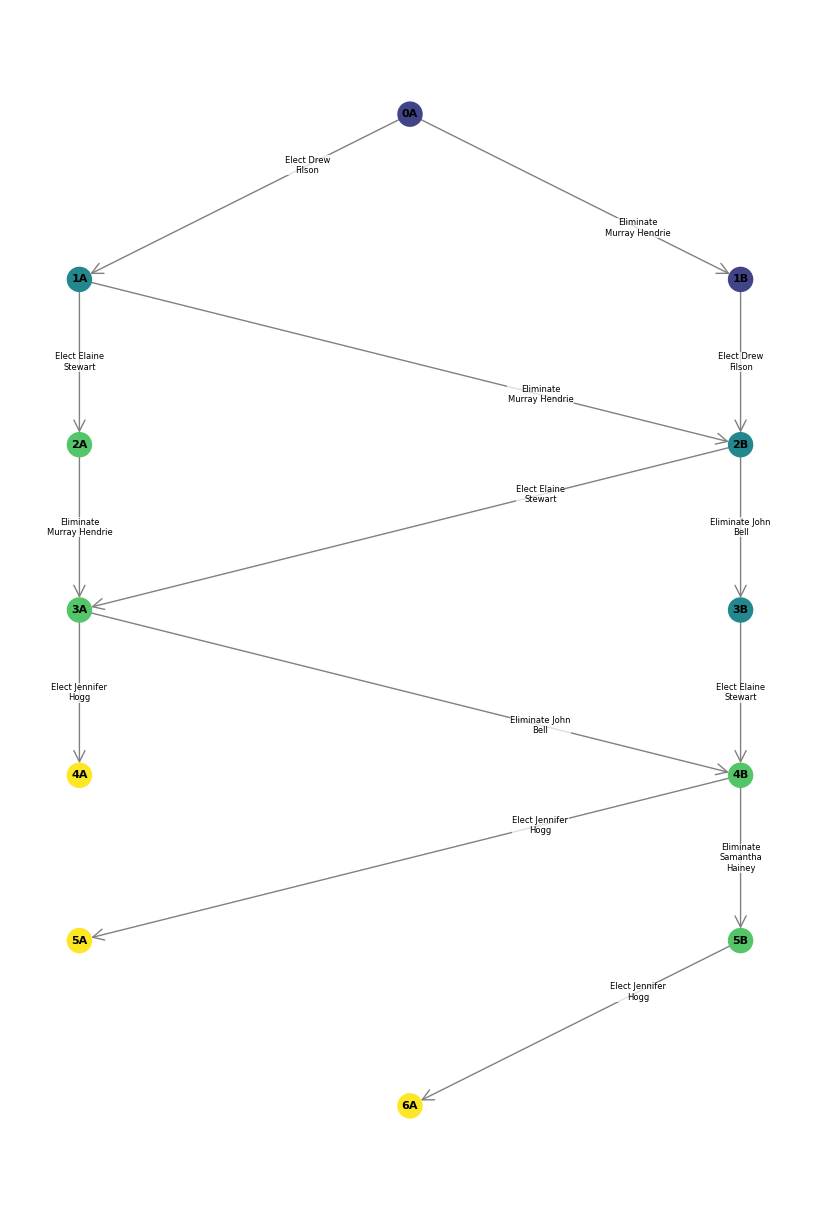

In [5]:
from src.edouard.MeekGraph import MeekGraph

audit_graph = MeekGraph(profile=profile, m=3, auditable_margins_per_deg=[141,141,141], use_numerical_labels=False)
audit_graph.plot_graph(figsize=(8,12), node_size=300, label_nodes=True, title=f"", label_edges=True, vertical_spacing=1000)

In [6]:
from src.edouard.src.margin_audits import end_to_end_synthetic_audit_3seat

end_to_end_synthetic_audit_3seat(profile, audit_graph, int(profile.total_ballot_wt//100), sample_size_fraction=1/15, alpha=.05, noise_level=0.02, hypergeo_var_bounds = [],epsilon=1e-6, verbose=True)

{mug: 0, mu1: 0, mu2: -N*(m + 1)*(N*mu21 + T21) + N*(N*nu12 + t12) + N*(N*nu21 + t21), mu12: -N*(m + 1)*(N*mu21 + T21) - N*(N*nu2 + t2), mu21: N*(N*nu12 + t12) + N*(N*nu2 + t2) + N*(N*nu21 + t21) - (m + 1)*(N*(N*mu12 + T12) + N*(N*mu2 + T2)), nu1: 0, nu2: -N*(N*mu12 + T12) + N*(N*mu21 + T21), nu12: N*(N*mu2 + T2) + N*(N*mu21 + T21), nu21: N*(N*mu2 + T2) + N*(N*mu21 + T21)}
Number of ballots N: 3904
Sample size n: 260
using the following hypergeo_var_bounds: [0.011014344262295082, 0.017418032786885244, 0.0233094262295082, 0.028944672131147542, 0.03406762295081967]
-------------------------- Auditing node 0A with degree 0 ------------------
First round results at node 0A:
FPV scores: {0: np.float64(311.0), 1: np.float64(1077.0), 2: np.float64(644.0), 3: np.float64(137.0), 4: np.float64(803.0), 5: np.float64(894.0)}
Quota: 966.500001
Initial losers: []
Initial winners: []
Canonical loser: 3
Allowable winners: [1]
Allowable losers: [3]
Succesfully checked that candidate John Bell does not 

True

In [ ]:
audit_graph.lookup_node('1C')

0.0103910479

In [8]:
from src.edouard.audit_machinery import deg0_cand_to_cand, deg0_cand_to_quota

#num_ghosts = 100
alpha = 0.05

general_kwargs = {
    'profile': profile,
    'm': 3,
    'n': BAL.shape[0],
    'alpha': alpha,
    'num_ghosts': num_ghosts, #(profile.total_ballot_wt//10),
    'z': NormalDist().inv_cdf(1 - alpha),
    'K': K_upper(int(profile.total_ballot_wt + num_ghosts), BAL.shape[0], alpha),
    'N': int(profile.total_ballot_wt + num_ghosts),
    'BAL': BAL,
    'CVR': CVR,
    'epsilon': 1e-6,
    'ballot_matrix': ballot_matrix,
    'mult_vec': mult_vec
}


def deg0_node_audit(str_node_ID, graph, deg0_kwargs, verbose = False):
    node_info = graph.lookup_node(str_node_ID)
    depth = node_info['layer']
    canonical_loser = node_info.get('canonical_loser', None)
    next_layer_codes = graph.nodes_by_layer[depth + 1]
    allowable_losers, allowable_winners = [], []
    for code in next_layer_codes:
        decoded = graph.decode_node_string(code)
        if set(decoded["winner_to_cand"]) >= set(node_info["winner_to_cand"]) and set(decoded["initial_losers"]) >= set(node_info["initial_losers"]):
            if len(decoded["winner_to_cand"]) == len(node_info["winner_to_cand"]) + 1:
                new_winner = list(set(decoded["winner_to_cand"]) - set(node_info["winner_to_cand"]))
                allowable_winners.append(new_winner[0])
            elif len(decoded["initial_losers"]) == len(node_info["initial_losers"]) + 1:
                new_loser = list(set(decoded["initial_losers"]) - set(node_info["initial_losers"]))
                allowable_losers.append(new_loser[0])
    projected_BAL_fpv, _ = project_matrix_onto_election_state(
        deg0_kwargs['BAL'],
        num_cands=len(profile.candidates),
        m=deg0_kwargs['m'],
        losers=node_info['initial_losers'])
    projected_CVR_fpv, _ = project_matrix_onto_election_state(
        deg0_kwargs['CVR'],
        num_cands=len(profile.candidates),
        m=deg0_kwargs['m'],
        losers=node_info['initial_losers'])
    core = MeekCore(
        profile=deg0_kwargs['profile'],
        m=deg0_kwargs['m'],
        candidates=list(deg0_kwargs['profile'].candidates),
        initial_losers=node_info['initial_losers']
    )
    fpv_scores, helper_vecs, play, tiebreak, quota = core._run_first_round()
    if verbose:
        print(f"First round results at node {str_node_ID}:")
        print(f"FPV scores: {fpv_scores}")
        print(f"Quota: {quota}")
        print(f"Initial losers: {node_info['initial_losers']}")
        print(f"Initial winners: {node_info['winner_to_cand']}")
        print(f"Canonical loser: {canonical_loser}")
        print(f"Allowable winners: {allowable_winners}")
        print(f"Allowable losers: {allowable_losers}")
    fpc = (deg0_kwargs['N'] - deg0_kwargs['n']) / (deg0_kwargs['n'] * (deg0_kwargs['N'] - 1)) #lol
    g = deg0_kwargs['N']- sum(fpv_scores)
    #print(fpv_scores)
    delta_vecs = {i: (projected_BAL_fpv == i).astype(int) - (projected_CVR_fpv == i).astype(int) for i in range(len(profile.candidates))}
    delta_vecs[-127] = (projected_BAL_fpv < 0).astype(int) - (projected_CVR_fpv < 0).astype(int)
    node_succesfully_audited = True
    hopeful_candidates = [c for c in range(len(profile.candidates)) if c not in node_info['initial_losers'] and c not in node_info['winner_to_cand']]
    if node_info.get('canonical_winner', None) is not None:
        canonical_winner = node_info['canonical_winner']
        # just do a cand-to-quota audit for the canonical winner
        T_0 = fpv_scores[canonical_winner] - (deg0_kwargs['N'] - g)/(deg0_kwargs['m']+1) - deg0_kwargs['epsilon']
        d_iq = delta_vecs[canonical_winner].astype(int) + delta_vecs[-127].astype(int)/(deg0_kwargs['m']+1)
        mean_diq = np.mean(d_iq)
        print("mean_diq", mean_diq) 
        sample_variance = np.var(d_iq, ddof=1) if np.any(d_iq != 0) else 4 * deg0_kwargs['K'] / deg0_kwargs['N']
        print("sample variance", sample_variance)
        print("sample variance of means", sample_variance/767) 
        st_dev = math.sqrt(sample_variance * fpc)
        print("SE", st_dev)
        M_lower = T_0 + deg0_kwargs['N'] * (mean_diq - deg0_kwargs['z'] * st_dev)
        if M_lower < 0:
            print(f"AUDIT FAILED at node {str_node_ID}: canonical winner {profile.candidates[canonical_winner]} might not have quota, M_cq > {M_lower} and T_cq = {T_0}")
            print(M_lower)
            node_succesfully_audited = False
        elif verbose:
            print(f"Succesfully checked that candidate {profile.candidates[canonical_winner]} must have quota at node {str_node_ID}, M_cq > {M_lower} and T_cq = {T_0}")
        return node_succesfully_audited
    for c in hopeful_candidates:
        if c not in allowable_winners:
            T_0 = fpv_scores[c] - (deg0_kwargs['N'] - g)/(deg0_kwargs['m']+1) - deg0_kwargs['epsilon']
            d_iq = delta_vecs[c].astype(int) + delta_vecs[-127].astype(int)/(deg0_kwargs['m']+1)
            mean_diq = np.mean(d_iq)
            sample_variance = np.var(d_iq, ddof=1) if np.any(d_iq != 0) else 4 * deg0_kwargs['K'] / deg0_kwargs['N']
            st_dev = math.sqrt(sample_variance * fpc)
            print("SE", st_dev)
            M_upper = T_0 + deg0_kwargs['N'] * (mean_diq + deg0_kwargs['z'] * st_dev)
            if M_upper > 0:
                print(f"AUDIT FAILED at node {str_node_ID}: candidate {profile.candidates[c]} might have quota.")
                print(M_upper)
                node_succesfully_audited = False
            elif verbose:
                print(f"Succesfully checked that candidate {profile.candidates[c]} does not have quota at node {str_node_ID}, M_cq < {M_upper} and T_cq = {T_0}")
        if c not in allowable_losers: # check the M_{cl} is positive
            deltas = delta_vecs[c] - delta_vecs[canonical_loser]
            delta_mean = np.mean(deltas)
            delta_sample_var = np.var(deltas, ddof=1) if np.any(deltas != 0) else 4 * deg0_kwargs['K'] / deg0_kwargs['N']
            st_dev = math.sqrt(delta_sample_var * fpc)
            T_cl = fpv_scores[c] - fpv_scores[canonical_loser]
            M_lower = T_cl + deg0_kwargs['N'] * (delta_mean - deg0_kwargs['z'] * st_dev)
            if M_lower <= 0:
                print(f"AUDIT FAILED at node {str_node_ID}: candidate {profile.candidates[c]} might lose to {profile.candidates[canonical_loser]}: M_cl < {M_lower} and T_cl = {T_cl}")
                print(M_lower)
                node_succesfully_audited = False
            elif verbose:
                print(f"Succesfully checked that candidate {profile.candidates[c]} does not lose to {profile.candidates[canonical_loser]} at node {str_node_ID}, M_cl > {M_lower} and T_cl = {T_cl}")
    return node_succesfully_audited

deg0_node_audit('0A', audit_graph, deg0_kwargs=general_kwargs, verbose=True)

First round results at node 0A:
FPV scores: [ 114. 1086. 1333.  974.  198.  808.  578.  432.]
Quota: 1380.750001
Initial losers: []
Initial winners: []
Canonical loser: 0
Allowable winners: [1, 2]
Allowable losers: [0, 4]
SE 0.0021408769505934905
Succesfully checked that candidate Glen Barclay does not have quota at node 0A, M_cq < -1224.5838848118335 and T_cq = -1266.750001
Succesfully checked that candidate Colin Brown does not lose to Glen Barclay at node 0A, M_cl > 909.0072822682969 and T_cl = 972.0
Succesfully checked that candidate Braden Davy does not lose to Glen Barclay at node 0A, M_cl > 1117.5925462471198 and T_cl = 1219.0
SE 0.0017687361870189025
Succesfully checked that candidate Lynne Devine does not have quota at node 0A, M_cq < -390.2454732732445 and T_cq = -406.750001
Succesfully checked that candidate Lynne Devine does not lose to Glen Barclay at node 0A, M_cl > 812.5238861556638 and T_cl = 860.0
SE 0.0012861986631282451
Succesfully checked that candidate Ed Mcadam do

True

In [9]:
def deg1_node_audit(str_node_ID, graph, deg1_kwargs, verbose = False):
    N = deg1_kwargs['N']
    m = deg1_kwargs['m']
    BAL = deg1_kwargs['BAL']
    CVR = deg1_kwargs['CVR']
    epsilon = deg1_kwargs['epsilon']
    K = deg1_kwargs['K']
    n = deg1_kwargs['n']
    z = deg1_kwargs['z']
    num_ghosts = deg1_kwargs['num_ghosts']

    node_info = graph.lookup_node(str_node_ID)
    print(node_info)
    depth = node_info['layer']
    canonical_loser = node_info.get('canonical_loser', None)
    if canonical_loser is None:
        raise ValueError("deg1_node_audit requires a canonical_loser in node_info")
    next_layer_codes = graph.nodes_by_layer[depth + 1]
    allowable_losers, allowable_winners = [], []
    for code in next_layer_codes:
        decoded = graph.decode_node_string(code)
        if set(decoded["winner_to_cand"]) >= set(node_info["winner_to_cand"]) and set(decoded["initial_losers"]) >= set(node_info["initial_losers"]):
            if len(decoded["winner_to_cand"]) == len(node_info["winner_to_cand"]) + 1:
                new_winner = list(set(decoded["winner_to_cand"]) - set(node_info["winner_to_cand"]))
                allowable_winners.append(new_winner[0])
            elif len(decoded["initial_losers"]) == len(node_info["initial_losers"]) + 1:
                new_loser = list(set(decoded["initial_losers"]) - set(node_info["initial_losers"]))
                allowable_losers.append(new_loser[0])
    projected_BAL_fpv, BAL_winner_comb = project_matrix_onto_election_state(
        BAL,
        num_cands=len(profile.candidates),
        m=m,
        losers=node_info['initial_losers'],
        winner_to_cand=node_info['winner_to_cand'])
    projected_CVR_fpv, CVR_winner_comb = project_matrix_onto_election_state(
        CVR,
        num_cands=len(profile.candidates),
        m=m,
        losers=node_info['initial_losers'],
        winner_to_cand=node_info['winner_to_cand'])
    #core = MeekCore(
    #    profile=deg1_kwargs['profile'],
    #    m=m,
    #    candidates=list(deg1_kwargs['profile'].candidates),
    #    initial_losers=node_info['initial_losers'],
    #    winner_to_cand=node_info['winner_to_cand']
    #)
    helper_fpv_vec, helper_winner_comb = project_matrix_onto_election_state(deg1_kwargs['ballot_matrix'], num_cands=len(profile.candidates), m=m, losers=node_info['initial_losers'], winner_to_cand=node_info['winner_to_cand'])

    fpc = (N - n) / (n * (N- 1))
    mult_vec = deg1_kwargs['mult_vec']
    g = np.sum(mult_vec[(helper_fpv_vec < 0) & (helper_winner_comb == 0)]) + num_ghosts

    deg0_scores = {i: sum(mult_vec[(helper_fpv_vec == i) & (helper_winner_comb == 0)]) for i in range(len(profile.candidates))}
    deg0_scores[-1] = sum(mult_vec[(helper_fpv_vec < 0) & (helper_winner_comb == 0)])
    deg1_scores = {i: sum(mult_vec[(helper_fpv_vec == i) & (helper_winner_comb == 1)]) for i in range(len(profile.candidates))}
    deg1_scores[-1] = sum(mult_vec[(helper_fpv_vec < 0) & (helper_winner_comb == 1)])

    Tw = sum(mult_vec[helper_winner_comb == 1])
    print(f"Tw: {Tw}, g: {g}")

    deg0_deltas = {i: ((projected_BAL_fpv == i) & (BAL_winner_comb == 0)).astype(int) - ((projected_CVR_fpv == i) & (CVR_winner_comb == 0)).astype(int) for i in range(len(profile.candidates))}
    deg0_deltas[-1] = ((projected_BAL_fpv < 0) & (BAL_winner_comb == 0)).astype(int) - ((projected_CVR_fpv < 0) & (CVR_winner_comb == 0)).astype(int)
    deg1_deltas = {i: ((projected_BAL_fpv == i) & (BAL_winner_comb == 1)).astype(int) - ((projected_CVR_fpv == i) & (CVR_winner_comb == 1)).astype(int) for i in range(len(profile.candidates))}
    deg1_deltas[-1] = ((projected_BAL_fpv < 0) & (BAL_winner_comb == 1)).astype(int) - ((projected_CVR_fpv < 0) & (CVR_winner_comb == 1)).astype(int)
    w_deltas = (BAL_winner_comb.astype(int) - CVR_winner_comb.astype(int))

    node_succesfully_audited = True
    hopeful_candidates = [c for c in range(len(profile.candidates)) if c not in node_info['initial_losers'] and c not in node_info['winner_to_cand']]

    Cu = N - g - deg1_scores[-1] + (m+1)*epsilon
    Cv = (m+1)*Tw - deg1_scores[-1]

    du_sample = deg0_deltas[-1].astype(int) + deg1_deltas[-1].astype(int)
    dv_sample = (m+1)*w_deltas - deg1_deltas[-1].astype(int)
    mu_u = np.mean(du_sample)
    mu_v = np.mean(dv_sample)
    k_hat = (Cu-N*mu_u)/(Cv+N*mu_v)

    if verbose:
        print(f"info at node {str_node_ID}: deg0_scores= {deg0_scores}, deg1_scores= {deg1_scores}, Tw = {Tw}, g = {g}, k_hat= {k_hat}")
        print(f"Cu= {Cu}, Cv= {Cv}, mu_u= {mu_u}, mu_v= {mu_v}")

    if node_info.get('canonical_winner', None) is not None:
        canonical_winner = node_info['canonical_winner']
        # just do a cand-to-quota audit for the canonical winner
        C0 = deg0_scores[canonical_winner] + deg1_scores[canonical_winner] 
        C1 = deg1_scores[canonical_winner] + Tw

        d0_sample = deg0_deltas[canonical_winner].astype(int) + deg1_deltas[canonical_winner].astype(int)
        d1_sample = deg1_deltas[canonical_winner].astype(int) + w_deltas

        mu_0 = np.mean(d0_sample)
        mu_1 = np.mean(d1_sample)

        grad_M = np.array([N,-k_hat * N,N*(C1+ N*mu_1)/(Cv+N*mu_v), -k_hat * N* (C1+ N*mu_1)/(Cv+N*mu_v)])
        min_variances = [4*K/N, 4*K/N, 4*K/N, (m+2)**2*K/N]
        covariance_matrix = np.cov([np.array(d0_sample), np.array(d1_sample), np.array(du_sample), np.array(dv_sample)], ddof=1)
        for i in range(len(min_variances)):
            if covariance_matrix[i,i] < min_variances[i]:
                covariance_matrix[i,i] = min_variances[i]
        delta_variance = grad_M @ covariance_matrix @ grad_M.T
        delta_variance *= fpc

        M = C0 + N*mu_0 - k_hat* (C1 + N*mu_1)
        M_lower = M - z * math.sqrt(delta_variance)
        if M_lower < 0:
            print(f"AUDIT FAILED at node {str_node_ID}: canonical winner {profile.candidates[canonical_winner]} might not have quota: M_cq < {M_lower} and estimate M_cq= {M}, k_hat= {k_hat}.")
            print(M_lower)
            node_succesfully_audited = False
        elif verbose:
            print(f"Succesfully checked that candidate {profile.candidates[canonical_winner]} must have quota at node {str_node_ID}, M_cq > {M_lower} and estimate M_cq= {M}, k_hat= {k_hat}.")
        return node_succesfully_audited
        
    for c in hopeful_candidates:
        if c not in allowable_winners:
            C0 = deg0_scores[c] + deg1_scores[c] 
            C1 = deg1_scores[c] + Tw
            
            d0_sample = deg0_deltas[c].astype(int) + deg1_deltas[c].astype(int)
            d1_sample = deg1_deltas[c].astype(int) + w_deltas

            mu_0 = np.mean(d0_sample)
            mu_1 = np.mean(d1_sample)

            grad_M = np.array([N,-k_hat * N,N*(C1+ N*mu_1)/(Cv+N*mu_v), -k_hat * N* (C1+ N*mu_1)/(Cv+N*mu_v)])
            min_variances = [4*K/N, 4*K/N, 4*K/N, (m+2)**2*K/N]
            covariance_matrix = np.cov([np.array(d0_sample), np.array(d1_sample), np.array(du_sample), np.array(dv_sample)], ddof=1)
            for i in range(len(min_variances)):
                if covariance_matrix[i,i] < min_variances[i]:
                    covariance_matrix[i,i] = min_variances[i]
            delta_variance = grad_M @ covariance_matrix @ grad_M.T
            delta_variance *= fpc

            M = C0 + N*mu_0 - k_hat* (C1 + N*mu_1)
            M_upper = M + z * math.sqrt(delta_variance)
            if M_upper > 0:
                print(f"AUDIT FAILED at node {str_node_ID}: candidate {profile.candidates[c]} might have quota: M_cq < {M_upper} and estimate M_cq= {M}, k_hat= {k_hat}.")
                print(M_upper)
                node_succesfully_audited = False
            elif verbose:
                print(f"Succesfully checked that candidate {profile.candidates[c]} does not have quota at node {str_node_ID}, M_cq < {M_upper} and estimate M_cq= {M}, k_hat= {k_hat}")
        if c not in allowable_losers:
            C0 = deg0_scores[c] - deg0_scores[canonical_loser] + deg1_scores[c] - deg1_scores[canonical_loser]
            C1 = deg1_scores[c] - deg1_scores[canonical_loser]

            d0_sample = deg0_deltas[c].astype(int) - deg0_deltas[canonical_loser].astype(int) + deg1_deltas[c].astype(int) - deg1_deltas[canonical_loser].astype(int)
            d1_sample = deg1_deltas[c].astype(int) - deg1_deltas[canonical_loser].astype(int) 
            mu_0 = np.mean(d0_sample)
            mu_1 = np.mean(d1_sample)
            grad_M = np.array([N,-k_hat * N,N*(C1+ N*mu_1)/(Cv+N*mu_v), -k_hat * N* (C1+ N*mu_1)/(Cv+N*mu_v)])
            min_variances = [4*K/N, 4*K/N, 4*K/N, (m+2)**2*K/N]
            covariance_matrix = np.cov([np.array(d0_sample), np.array(d1_sample), np.array(du_sample), np.array(dv_sample)], ddof=1)
            for i in range(len(min_variances)):
                if covariance_matrix[i,i] < min_variances[i]:
                    covariance_matrix[i,i] = min_variances[i]
            delta_variance = grad_M @ covariance_matrix @ grad_M.T
            if c == 1:
                print(f"delta_variance candidate {c}: {delta_variance}")
                print(f"grad_M: {to_latex_column(grad_M)}")
                print(f"covariance_matrix: {to_latex_matrix(covariance_matrix)}")
                print(f"d0_sample_nonzero: {sum(d1_sample != 0)}")
                print(f"d0_sample_variance: {np.var(d1_sample, ddof=1)}")
                print(f"min_variance: {min_variances}")
            delta_variance *= fpc
            print(f"delta_variance: {delta_variance}")
            print(f"stddev: {math.sqrt(delta_variance)}")

            M = C0 + N*mu_0 - k_hat* (C1 + N*mu_1)
            M_lower = M - z * math.sqrt(delta_variance)
            if M_lower <= 0:
                print(f"AUDIT FAILED at node {str_node_ID}: candidate {profile.candidates[c]} might lose to {profile.candidates[canonical_loser]}. M_cl < {M_lower} and estimate M_cl= {M}, k_hat= {k_hat}.")
                print(M_lower)
                node_succesfully_audited = False
            elif verbose:
                print(f"Succesfully checked that candidate {profile.candidates[c]} does not lose to {profile.candidates[canonical_loser]} at node {str_node_ID}, M_cl > {M_lower} and estimate M_cl= {M}, k_hat= {k_hat}")
    return node_succesfully_audited

deg1_node_audit('1A', audit_graph, deg1_kwargs=general_kwargs, verbose=True)

{'node_id': '1A', 'layer': 1, 'position_in_layer': 0, 'winner_to_cand': [np.int64(1)], 'initial_losers': [], 'winners': ['Colin Brown'], 'losers': [], 'canonical_loser': np.int64(0), 'canonical_winner': None, 'other_plausible_winners': None}
Tw: 1086.0, g: 150.0
info at node 1A: deg0_scores= {0: np.float64(114.0), 1: 0, 2: np.float64(1333.0), 3: np.float64(974.0), 4: np.float64(198.0), 5: np.float64(808.0), 6: np.float64(578.0), 7: np.float64(432.0), -1: 0}, deg1_scores= {0: np.float64(20.0), 1: 0, 2: np.float64(95.0), 3: np.float64(69.0), 4: np.float64(35.0), 5: np.float64(565.0), 6: np.float64(41.0), 7: np.float64(173.0), -1: np.float64(88.0)}, Tw = 1086.0, g = 150.0, k_hat= 1.2775029400158777
Cu= 5435.000004, Cv= 4256.0, mu_u= 0.001303780964797914, mu_v= -0.001303780964797914
Succesfully checked that candidate Glen Barclay does not have quota at node 1A, M_cq < -1159.2701873128294 and estimate M_cq= -1256.729203417665, k_hat= 1.2775029400158777
delta_variance: 1504.614582141025
stdd

True

In [10]:
import sympy as sp
import numpy as np

#
# 0. Symbols
#

# Parameters that appear in A2,B2,C2 (you can treat these as the θ_i if you like)
T1, T2, T12, T21 = sp.symbols('T1 T2 T12 T21', real=True)
mu1, mu2, mu12, mu21, mug = sp.symbols('mu1 mu2 mu12 mu21 mug', real=True)
t1, t2, t12, t21 = sp.symbols('t1 t2 t12 t21', real=True)
nu1, nu2, nu12, nu21 = sp.symbols('nu1 nu2 nu12 nu21', real=True)
m, N, g, epsilon = sp.symbols('m N g epsilon', real=True)

# Keep factors
k1, k2 = sp.symbols('k1 k2', real=True)

#
# 1. A2, B2, C2 and the symmetric A1, B1, C1
#    (Equations (1)–(3) in your pdf.)
#

A2 = (
    (T2+N*mu2)*(t12+N*nu12)
    - (T12+N*mu12)*(t2+N*nu2)
    + (T2+N*mu2)*(t21+N*nu21)
    + (T21+N*mu21)*(t12+N*nu12)
    + (T21+N*mu21)*(t2+N*nu2)
    + (T21+N*mu21)*(t21+N*nu21)
    - (m + 1)*((T12+N*mu12)*(T21+N*mu21) + (T2+N*mu2)*(T21+N*mu21))
)

B2 = (
    - (T1+N*mu1)*(t12+N*nu12)
    - (T1+N*mu1)*(t2+N*nu2)
    + (T12+N*mu12)*(t2+N*nu2)
    - (T2+N*mu2)*(t1+N*nu1)
    - (T2+N*mu2)*(t12+N*nu12)
    - (T1+N*mu1)*(t21+N*nu21)
    - (T2+N*mu2)*(t21+N*nu21)
    + (N - (g+N*mug))*((T21+N*mu21) - (T12+N*mu12))
    - (T21+N*mu21)*(t1+N*nu1)
    - 2*((T21+N*mu21)*(t12+N*nu12) + (T21+N*mu21)*(t2+N*nu2) + (T21+N*mu21)*(t21+N*nu21))
    + (m + 1)*((T1+N*mu1)*(T12+N*mu12) + (T1+N*mu1)*(T2+N*mu2) + (T12+N*mu12)*(T21+N*mu21) + (T2+N*mu2)*(T21+N*mu21) - (T12+N*mu12)*epsilon + (T21+N*mu21)*epsilon)
)

C2 = - (T1 + N*mu1 + T21 + N*mu21) * (
    N - (g + N*mug) - t1 - N*nu1 - t12 - N*nu12 - t2 - N*nu2 - t21 - N*nu21 + (m + 1)*epsilon
)

# Helper: swap indices 1 <-> 2 to get A1,B1,C1
_swap_pairs = [(T1, T2), (t1, t2), (T12, T21), (t12, t21), (mu1, mu2), (nu1, nu2), (mu12, mu21), (nu12, nu21)]

def _swap_1_2(expr: sp.Expr) -> sp.Expr:
    """Swap indices 1 and 2 in an expression (T1<->T2, t1<->t2, 12<->21)."""
    out = expr
    for a, b in _swap_pairs:
        tmp = sp.Symbol(f'__tmp_{a.name}')
        # a -> tmp, b -> a, then tmp -> b
        out = out.subs({a: tmp, b: a})
        out = out.subs({tmp: b})
    return out

A1 = _swap_1_2(A2)
B1 = _swap_1_2(B2)
C1 = _swap_1_2(C2)

# Polynomials P1(θ,k1) and P2(θ,k2)
P1 = A1*k1**2 + B1*k1 + C1
P2 = A2*k2**2 + B2*k2 + C2

#
# 2. ∂θ A, ∂θ B, ∂θ C and implicit ∂θ k via IFT
#

# Choose which symbols you want to treat as θ_i for the keep factors.
# You can modify this list to match your actual θ-vector.
poly_constants = [T1, T2, T12, T21,
              t1, t2, t12, t21, g, N, m, epsilon]
theta_poly = [mug, mu1, mu2, mu12, mu21,
              nu1, nu2, nu12, nu21]

# Derivatives of A1,B1,C1 and A2,B2,C2 w.r.t each θ_i
dA1 = {th: sp.diff(A1, th) for th in theta_poly}
dB1 = {th: sp.diff(B1, th) for th in theta_poly}
dC1 = {th: sp.diff(C1, th) for th in theta_poly}

dA2 = {th: sp.diff(A2, th) for th in theta_poly}
dB2 = {th: sp.diff(B2, th) for th in theta_poly}
dC2 = {th: sp.diff(C2, th) for th in theta_poly}

print(dA2)

# Implicit Function Theorem:
# ∂k/∂θ_i = - ( (∂θ A) k^2 + (∂θ B) k + (∂θ C) ) / (2 A k + B)

dk1 = {
    th: - (dA1[th]*k1**2 + dB1[th]*k1 + dC1[th]) / (2*A1*k1 + B1)
    for th in theta_poly
}

dk2 = {
    th: - (dA2[th]*k2**2 + dB2[th]*k2 + dC2[th]) / (2*A2*k2 + B2)
    for th in theta_poly
}

#
# 3. Symbolic M_ij(θ, k1, k2)
#    Using the formula in the pdf (with check T's and μ's as separate symbols).
#

# Check-T totals (treated as constants w.r.t θ unless you add them to θ)
T_i, T_j = sp.symbols('T_i T_j', real=True)
T_w1i, T_w1j = sp.symbols('T_w1i T_w1j', real=True)
T_w2i, T_w2j = sp.symbols('T_w2i T_w2j', real=True)
T_w1w2i, T_w1w2j = sp.symbols('T_w1w2i T_w1w2j', real=True)

# μ parameters that appear directly in the margin
mu_i, mu_j = sp.symbols('mu_i mu_j', real=True)
mu_w1i, mu_w1j = sp.symbols('mu_w1i mu_w1j', real=True)
mu_w2i, mu_w2j = sp.symbols('mu_w2i mu_w2j', real=True)
mu_w1w2i, mu_w1w2j = sp.symbols('mu_w1w2i mu_w1w2j', real=True)

M_ij = (
    (T_i - T_j)
    + N*(mu_i - mu_j)
    + (1 - k1)*(1 - k2)*(
        T_w1w2i - T_w1w2j + N*(mu_w1w2i - mu_w1w2j)
    )
    + (1 - k1)*(
        T_w1i - T_w1j + N*(mu_w1i - mu_w1j)
    )
    + (1 - k2)*(
        T_w2i - T_w2j + N*(mu_w2i - mu_w2j)
    )
)

#
# 4. ∇_θ M_ij, using the precomputed ∂θ k1, ∂θ k2
#

# Extend θ to include whichever μ's you want derivatives for.
# This is the θ-vector for the margin. Adjust to match your preferred ordering.
theta_margin_extra = [
    mu_i, mu_j,
    mu_w1i, mu_w1j,
    mu_w2i, mu_w2j,
    mu_w1w2i, mu_w1w2j,
] #NB: these could be combined pairwise, e.g., mu_i - mu_j, decreasing the number of parameters.

theta_full = theta_poly + theta_margin_extra

# Gradient entries: ∂θ M = ∂θ M |_k fixed + (∂M/∂k1) ∂θ k1 + (∂M/∂k2) ∂θ k2
grad_M_exprs = []
dM_dk1 = sp.diff(M_ij, k1)
dM_dk2 = sp.diff(M_ij, k2)

for th in theta_full:
    dM_direct = sp.diff(M_ij, th)
    dM_via_k1 = dM_dk1 * dk1.get(th, 0)
    dM_via_k2 = dM_dk2 * dk2.get(th, 0)
    grad_M_exprs.append(dM_direct + dM_via_k1 + dM_via_k2)

# grad_M_exprs[i] is ∂M/∂θ_full[i]


#
# 5. Numerical evaluation of ∇_θ M_ij
#

# All symbols that need numeric values for evaluation
all_syms_for_eval = (
    theta_full
    + poly_constants     
    + [T_i, T_j,
       T_w1i, T_w1j,
       T_w2i, T_w2j,
       T_w1w2i, T_w1w2j,
       k1, k2]
)

_grad_M_func = sp.lambdify(all_syms_for_eval, grad_M_exprs, 'numpy')


def eval_grad_M(
    mu_values: dict,
    Tcheck_values: dict,
    k_values: dict,
) -> np.ndarray:
    """
    Evaluate ∇_θ M_ij at numerical values.

    Parameters
    ----------
    mu_values : dict
        Numerical values for μ parameters in the margin:
        keys: mu_i, mu_j, mu_w1i, mu_w1j, mu_w2i, mu_w2j, mu_w1w2i, mu_w1w2j, mu1, mu2, mu12, mu21, mug, nu1, nu2, nu12, nu21.
    Tcheck_values : dict
        Numerical values for check-* totals:
        keys: T_i, T_j, T_w1i, T_w1j, T_w2i, T_w2j, T_w1w2i, T_w1w2j, T1, T2, T12, T21, t1, t2, t12, t21, g, N, m, epsilon.
    k_values : dict
        Numerical values for the keep factors:
        keys: k1, k2 (the roots you solved for separately).

    Returns
    -------
    grad : np.ndarray, shape (len(theta_full),)
        Gradient vector ∇_θ M_ij in the order given by `theta_full`.
    """
    # Merge all dicts keyed by SymPy symbols
    subs = {}
    subs.update(mu_values)
    subs.update(Tcheck_values)
    subs.update(k_values)

    # Build argument list in the correct order
    args = [subs[sym] for sym in all_syms_for_eval]
    grad_vals = _grad_M_func(*args)
    return np.asarray(grad_vals, dtype=float)

# --- Lambdify for M_ij itself (no variance) ---

# All symbols that M_ij actually depends on
M_syms_for_eval = [
    mu_i, mu_j,
    mu_w1i, mu_w1j,
    mu_w2i, mu_w2j,
    mu_w1w2i, mu_w1w2j,
    T_i, T_j,
    T_w1i, T_w1j,
    T_w2i, T_w2j,
    T_w1w2i, T_w1w2j,
    N, k1, k2,
]

_M_func = sp.lambdify(M_syms_for_eval, M_ij, 'numpy')


def eval_M(
    mu_values: dict,
    Tcheck_values: dict,
    k_values: dict,
) -> float:
    """
    Evaluate the margin M_ij at numerical values.

    Parameters
    ----------
    mu_values : dict
        Numerical values for μ parameters in the margin, e.g.:
        mu_i, mu_j, mu_w1i, mu_w1j, mu_w2i, mu_w2j, mu_w1w2i, mu_w1w2j, ...
    Tcheck_values : dict
        Numerical values for check-* totals and N (and friends if you like), e.g.:
        Tc_i, Tc_j, Tc_w1i, Tc_w1j, Tc_w2i, Tc_w2j, Tc_w1w2i, Tc_w1w2j, N, ...
    k_values : dict
        Numerical values for the keep factors:
        keys: k1, k2.

    Returns
    -------
    M : float
        The scalar value of M_ij at the given parameters.
    """
    subs = {}
    subs.update(mu_values)
    subs.update(Tcheck_values)
    subs.update(k_values)

    args = [subs[sym] for sym in M_syms_for_eval]
    M_val = _M_func(*args)
    return float(M_val)


{mug: 0, mu1: 0, mu2: -N*(m + 1)*(N*mu21 + T21) + N*(N*nu12 + t12) + N*(N*nu21 + t21), mu12: -N*(m + 1)*(N*mu21 + T21) - N*(N*nu2 + t2), mu21: N*(N*nu12 + t12) + N*(N*nu2 + t2) + N*(N*nu21 + t21) - (m + 1)*(N*(N*mu12 + T12) + N*(N*mu2 + T2)), nu1: 0, nu2: -N*(N*mu12 + T12) + N*(N*mu21 + T21), nu12: N*(N*mu2 + T2) + N*(N*mu21 + T21), nu21: N*(N*mu2 + T2) + N*(N*mu21 + T21)}


In [11]:
# 6. Quadratic roots for P1 and P2 via lambdify

# A1,B1,C1,A2,B2,C2 depend only on theta_poly
_P_coeff_syms = poly_constants + theta_poly
_P_coeffs_func = sp.lambdify(
    _P_coeff_syms,
    (A1, B1, C1, A2, B2, C2),
    'numpy'
)


def _real_roots_quadratic(A, B, C, tol=1e-12):
    """
    Return list of real roots of A x^2 + B x + C = 0 (0, 1, or 2 roots).
    Handles near-linear/degenerate cases in a simple way.
    """
    roots = []

    # Degenerate to linear?
    if abs(A) < tol:
        if abs(B) < tol:
            return roots  # constant equation: either no root or all x; ignore
        roots.append(-C / B)
        return roots

    disc = B * B - 4.0 * A * C
    if disc < -tol:
        return roots  # no real roots

    # Clamp very small negative discriminants to zero
    if disc < 0.0:
        disc = 0.0

    sqrt_disc = np.sqrt(disc)
    r1 = (-B - sqrt_disc) / (2.0 * A)
    r2 = (-B + sqrt_disc) / (2.0 * A)
    roots.extend([r1, r2])
    return roots


def eval_least_positive_root(mu_values, Tcheck_values,
                             tol=1e-12):
    """
    Using the same dict interface as eval_grad_M, evaluate A1,B1,C1,A2,B2,C2
    and return the least positive real root of P1(k1)=0 or P2(k2)=0.

        P1(k1) = A1 k1^2 + B1 k1 + C1
        P2(k2) = A2 k2^2 + B2 k2 + C2

    Parameters
    ----------
    theta_values : dict
        Numerical values for T1, T2, T12, T21, t1, t2, t12, t21, m, N, g, epsilon.
    mu_values : dict
        Ignored here; accepted for signature compatibility with eval_grad_M.
    Tcheck_values : dict
        Ignored here; accepted for signature compatibility with eval_grad_M.
    k_values : dict
        Ignored here; accepted for signature compatibility with eval_grad_M.
    tol : float
        Tolerance for detecting degeneracy / positivity.

    Returns
    -------
    k_min : float
        Least positive real root among roots of P1 and P2.

    Raises
    ------
    ValueError
        If no positive real roots are found.
    """
    # We only need theta_values, but we accept the other dicts for compatibility.
    subs = {}
    subs.update(Tcheck_values)
    subs.update(mu_values)

    # Build argument list for lambdified coeff function
    args = [subs[sym] for sym in _P_coeff_syms]
    A1v, B1v, C1v, A2v, B2v, C2v = _P_coeffs_func(*args)

    roots1 = []
    roots2 = []
    roots1.extend(_real_roots_quadratic(A1v, B1v, C1v, tol=tol))
    roots2.extend(_real_roots_quadratic(A2v, B2v, C2v, tol=tol))

    pos_roots_k1 = [float(r) for r in roots1 if r > tol]
    pos_roots_k2 = [float(r) for r in roots2 if r > tol]

    if not pos_roots_k1 or not pos_roots_k2:
        raise ValueError("No positive real roots for P1 or P2 at given parameters.")

    return min(pos_roots_k1), min(pos_roots_k2)


In [12]:
from votekit.elections.election_types.ranking.meek import perm_to_idx, idx_to_perm

def deg2_node_audit(str_node_ID, graph, deg2_kwargs, verbose = False):
    _N = deg2_kwargs['N']
    _m = deg2_kwargs['m']
    BAL = deg2_kwargs['BAL']
    CVR = deg2_kwargs['CVR']
    _epsilon = deg2_kwargs['epsilon']
    K = deg2_kwargs['K']
    _n = deg2_kwargs['n']
    z = deg2_kwargs['z']
    candidate_strs = deg2_kwargs['profile'].candidates
    num_cands = len(candidate_strs)

    if _m!= 3:
        raise ValueError("deg2_node_audit currently only supports m=3")
    
    node_info = graph.lookup_node(str_node_ID)
    remaining_candidates = [c for c in range(num_cands) if c not in node_info['initial_losers'] and c not in node_info['winner_to_cand']]
    
    if len(remaining_candidates) == 1:
        if verbose:
            print(f"Node {str_node_ID} only has one remaining candidate {candidate_strs[remaining_candidates[0]]}, automatically passing audit.")
        return True
    elif len(remaining_candidates) == 0:
        raise ValueError(f"Node {str_node_ID} has no remaining candidates, something went wrong.")
    else:
        canonical_loser = node_info.get('canonical_loser', None)
        if canonical_loser is None:
            raise ValueError("deg2_node_audit requires a canonical_loser in node_info")
        
    
    depth = node_info['layer']
    next_layer_codes = graph.nodes_by_layer[depth + 1]
    allowable_losers= []
    for code in next_layer_codes:
        decoded = graph.decode_node_string(code)
        if set(decoded["winner_to_cand"]) >= set(node_info["winner_to_cand"]) and set(decoded["initial_losers"]) >= set(node_info["initial_losers"]):
            if len(decoded["winner_to_cand"]) == len(node_info["winner_to_cand"]) + 1 and verbose:
                print(f"Skipping edge from node {str_node_ID} to {code} since deg2_node_audit only handles loser expansions.")
            elif len(decoded["initial_losers"]) == len(node_info["initial_losers"]) + 1:
                new_loser = list(set(decoded["initial_losers"]) - set(node_info["initial_losers"]))
                allowable_losers.append(new_loser[0])

    projected_BAL_fpv, BAL_winner_comb = project_matrix_onto_election_state(
        BAL,
        num_cands=len(profile.candidates),
        m=_m,
        losers=node_info['initial_losers'],
        winner_to_cand=node_info['winner_to_cand'])
    projected_CVR_fpv, CVR_winner_comb = project_matrix_onto_election_state(
        CVR,
        num_cands=len(profile.candidates),
        m=_m,
        losers=node_info['initial_losers'],
        winner_to_cand=node_info['winner_to_cand'])
    
    ## RESERVED SYMBOLS: DO NOT USE FOR OTHER PURPOSES
    #T1, T2, T12, T21 = sp.symbols('T1 T2 T12 T21', real=True)
    #mu1, mu2, mu12, mu21, mug = sp.symbols('mu1 mu2 mu12 mu21 mug', real=True)
    #t1, t2, t12, t21 = sp.symbols('t1 t2 t12 t21', real=True)
    #nu1, nu2, nu12, nu21 = sp.symbols('nu1 nu2 nu12 nu21', real=True)
    #m, N, g, epsilon = sp.symbols('m N g epsilon', real=True)
    #
    #k1, k2 = sp.symbols('k1 k2', real=True)
    #
    ##CANDIDATE SPECIFIC SYMBOLS
    #T_i, T_j = sp.symbols('T_i T_j', real=True)
    #T_w1i, T_w1j = sp.symbols('T_w1i T_w1j', real=True)
    #T_w2i, T_w2j = sp.symbols('T_w2i T_w2j', real=True)
    #T_w1w2i, T_w1w2j = sp.symbols('T_w1w2i T_w1w2j', real=True)
    #mu_i, mu_j = sp.symbols('mu_i mu_j', real=True)
    #mu_w1i, mu_w1j = sp.symbols('mu_w1i mu_w1j', real=True)
    #mu_w2i, mu_w2j = sp.symbols('mu_w2i mu_w2j', real=True)
    #mu_w1w2i, mu_w1w2j = sp.symbols('mu_w1w2i mu_w1w2j', real=True)

    # dicts with symbolic keys
    mu_values = {}
    Tcheck_values = {N: _N, m: _m, epsilon: _epsilon} 
    k_values = {}
    
    helper_fpv_vec, helper_winner_comb = project_matrix_onto_election_state(deg2_kwargs['ballot_matrix'], num_cands=len(profile.candidates), m=_m, losers=node_info['initial_losers'], winner_to_cand=node_info['winner_to_cand'])

    fpc = (_N - _n) / (_n * (_N- 1))
    mult_vec = deg2_kwargs['mult_vec']

    score_transfer_masks = {i: helper_winner_comb == i for i in [0,1,2,4,6]}
    score_fpv_masks = {i: helper_fpv_vec == i for i in remaining_candidates}
    score_fpv_masks[-1] = helper_fpv_vec < 0

    Tcheck_values[g] = np.sum(mult_vec[score_fpv_masks[-1] & (score_transfer_masks[0])]) + deg2_kwargs['num_ghosts']

    deg0_scores = {i: sum(mult_vec[score_fpv_masks[i] & score_transfer_masks[0]]) for i in remaining_candidates}
    deg0_scores[-1] = sum(mult_vec[score_fpv_masks[-1] & score_transfer_masks[0]])
    w1_scores = {i: sum(mult_vec[score_fpv_masks[i] & score_transfer_masks[1]]) for i in remaining_candidates}
    w1_scores[-1] = sum(mult_vec[score_fpv_masks[-1] & score_transfer_masks[1]])
    w2_scores = {i: sum(mult_vec[score_fpv_masks[i] & score_transfer_masks[2]]) for i in remaining_candidates}
    w2_scores[-1] = sum(mult_vec[score_fpv_masks[-1] & score_transfer_masks[2]])
    w1w2_scores = {i: sum(mult_vec[score_fpv_masks[i] & (score_transfer_masks[4]| score_transfer_masks[6])]) for i in remaining_candidates} # we don't care what order the transfer happens in
    #w1w2_scores[-1] = sum(mult_vec[score_fpv_masks[-1] & (score_transfer_masks[4]| score_transfer_masks[6])])

    Tcheck_values[T1] = sum(mult_vec[score_transfer_masks[1] | score_transfer_masks[4]])
    Tcheck_values[T2] = sum(mult_vec[score_transfer_masks[2]| score_transfer_masks[6]])
    Tcheck_values[T12] = sum(mult_vec[score_transfer_masks[4]])
    Tcheck_values[T21] = sum(mult_vec[score_transfer_masks[6]])
    Tcheck_values[t1] = w1_scores[-1]
    Tcheck_values[t2] = w2_scores[-1]
    Tcheck_values[t12] = sum(mult_vec[score_fpv_masks[-1] & score_transfer_masks[4]])
    Tcheck_values[t21] = sum(mult_vec[score_fpv_masks[-1] & score_transfer_masks[6]])

    # j is always the canonical loser, so fill those values in now
    Tcheck_values[T_j] = deg0_scores[canonical_loser] 
    Tcheck_values[T_w1j] = w1_scores[canonical_loser]
    Tcheck_values[T_w2j] = w2_scores[canonical_loser]
    Tcheck_values[T_w1w2j] = w1w2_scores[canonical_loser]

    BAL_fpv_masks = {i: (projected_BAL_fpv == i) for i in remaining_candidates}
    BAL_fpv_masks[-1] = (projected_BAL_fpv < 0)
    CVR_fpv_masks = {i: (projected_CVR_fpv == i) for i in remaining_candidates}
    CVR_fpv_masks[-1] = (projected_CVR_fpv < 0)
    BAL_transfer_masks = {i: (BAL_winner_comb == i) for i in [0,1,2,4,6]}
    CVR_transfer_masks = {i: (CVR_winner_comb == i) for i in [0,1,2,4,6]}

    deg0_deltas = {i: (BAL_fpv_masks[i] & BAL_transfer_masks[0]).astype(int) - (CVR_fpv_masks[i] & CVR_transfer_masks[0]).astype(int) for i in remaining_candidates}
    deg0_deltas[-1] = (BAL_fpv_masks[-1] & BAL_transfer_masks[0]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[0]).astype(int)
    w1_deltas = {i: (BAL_fpv_masks[i] & BAL_transfer_masks[1]).astype(int) - (CVR_fpv_masks[i] & CVR_transfer_masks[1]).astype(int) for i in remaining_candidates}
    w1_deltas[-1] = (BAL_fpv_masks[-1] & BAL_transfer_masks[1]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[1]).astype(int)
    w2_deltas = {i: (BAL_fpv_masks[i] & BAL_transfer_masks[2]).astype(int) - (CVR_fpv_masks[i] & CVR_transfer_masks[2]).astype(int) for i in remaining_candidates}
    w2_deltas[-1] = (BAL_fpv_masks[-1] & BAL_transfer_masks[2]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[2]).astype(int)
    w1w2_deltas = {i: ((BAL_fpv_masks[i] & (BAL_transfer_masks[4] | BAL_transfer_masks[6])).astype(int) - (CVR_fpv_masks[i] & (CVR_transfer_masks[4] | CVR_transfer_masks[6])).astype(int)) for i in remaining_candidates}
    
    mug_deltas = (BAL_fpv_masks[-1] & BAL_transfer_masks[0]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[0]).astype(int)
    mu1_deltas = BAL_transfer_masks[1].astype(int) - CVR_transfer_masks[1].astype(int)
    mu2_deltas = BAL_transfer_masks[2].astype(int) - CVR_transfer_masks[2].astype(int)
    nu1_deltas = (BAL_fpv_masks[-1] & BAL_transfer_masks[1]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[1]).astype(int)
    nu2_deltas = (BAL_fpv_masks[-1] & BAL_transfer_masks[2]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[2]).astype(int)
    mu12_deltas = BAL_transfer_masks[4].astype(int) - CVR_transfer_masks[4].astype(int)
    mu21_deltas = BAL_transfer_masks[6].astype(int) - CVR_transfer_masks[6].astype(int)
    nu12_deltas = (BAL_fpv_masks[-1] & BAL_transfer_masks[4]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[4]).astype(int)
    nu21_deltas = (BAL_fpv_masks[-1] & BAL_transfer_masks[6]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[6]).astype(int)
    
    mu_values[mug] = np.mean(mug_deltas.astype(int))
    mu_values[mu1] = np.mean(mu1_deltas.astype(int))
    mu_values[mu2] = np.mean(mu2_deltas.astype(int))
    mu_values[mu12] = np.mean(mu12_deltas.astype(int))
    mu_values[mu21] = np.mean(mu21_deltas.astype(int))
    mu_values[nu1] = np.mean(nu1_deltas.astype(int))
    mu_values[nu2] = np.mean(nu2_deltas.astype(int))
    mu_values[nu12] = np.mean(nu12_deltas.astype(int))
    mu_values[nu21] = np.mean(nu21_deltas.astype(int))

    print("Parameters for K: Tcheclk_values:")
    for key, value in Tcheck_values.items():
        print(f"  {key}: {value}")
    _k1, _k2 = eval_least_positive_root(mu_values, Tcheck_values)
    k_values[k1] = _k1
    k_values[k2] = _k2

    # again, j is always the canonical loser, so fill out the mu_*j
    mu_values[mu_j] = np.mean(deg0_deltas[canonical_loser].astype(int))
    mu_values[mu_w1j] = np.mean(w1_deltas[canonical_loser].astype(int))
    mu_values[mu_w2j] = np.mean(w2_deltas[canonical_loser].astype(int))
    mu_values[mu_w1w2j] = np.mean(w1w2_deltas[canonical_loser].astype(int))

    node_succesfully_audited = True

    if verbose:
        print(f"info at node {str_node_ID}: k1= {_k1}, k2= {_k2}")
    
    for c in remaining_candidates:
        if c not in allowable_losers and c != canonical_loser:
            Tcheck_values[T_i] = deg0_scores[c] 
            Tcheck_values[T_w1i] = w1_scores[c]
            Tcheck_values[T_w2i] = w2_scores[c]
            Tcheck_values[T_w1w2i] = w1w2_scores[c]

            mu_values[mu_i] = np.mean(deg0_deltas[c].astype(int))
            mu_values[mu_w1i] = np.mean(w1_deltas[c].astype(int))
            mu_values[mu_w2i] = np.mean(w2_deltas[c].astype(int))
            mu_values[mu_w1w2i] = np.mean(w1w2_deltas[c].astype(int))

            min_variance = 4 * K / _N
            # theta is: mug, mu1, mu2, mu12, mu21, nu1, nu2, nu12, nu21, mu_i, mu_j, mu_w1i, mu_w1j, mu_w2i, mu_w2j, mu_w1w2i, mu_w1w2j

            data = np.vstack([
                mug_deltas,
                mu1_deltas,
                mu2_deltas,
                mu12_deltas,
                mu21_deltas,
                nu1_deltas,
                nu2_deltas,
                nu12_deltas,
                nu21_deltas,
                deg0_deltas[c],
                deg0_deltas[canonical_loser],
                w1_deltas[c],
                w1_deltas[canonical_loser],
                w2_deltas[c],
                w2_deltas[canonical_loser],
                w1w2_deltas[c],
                w1w2_deltas[canonical_loser],
            ]).astype(float)

            covariance_matrix = np.cov(data, ddof=1)
            grad_M = eval_grad_M(mu_values, Tcheck_values, k_values)
            for i in range(covariance_matrix.shape[0]):
                if covariance_matrix[i,i] == 0:
                    covariance_matrix[i,i] = min_variance
            delta_variance = grad_M @ covariance_matrix @ grad_M.T
            delta_variance *= fpc
            print(f"delta_variance: {delta_variance}")

            M = eval_M(mu_values, Tcheck_values, k_values)

            M_lower = M - z * math.sqrt(abs(delta_variance))
            if M_lower <= 0:
                print(f"AUDIT FAILED at node {str_node_ID}: candidate {profile.candidates[c]} might lose to {profile.candidates[canonical_loser]}. M_cl < {M_lower} and estimate M_cl= {M}, k1= {k_values[k1]}, k2= {k_values[k2]}.")
                print(M_lower)
                node_succesfully_audited = False
            elif verbose:
                print(f"Succesfully checked that candidate {profile.candidates[c]} does not lose to {profile.candidates[canonical_loser]} at node {str_node_ID}, M_cl > {M_lower} and estimate M_cl= {M}, k1= {k_values[k1]}, k2= {k_values[k2]}.")
    return node_succesfully_audited

deg2_node_audit('3A', audit_graph, deg2_kwargs=general_kwargs, verbose=True)

Parameters for K: Tcheclk_values:
  N: 5673
  m: 3
  epsilon: 1e-06
  g: 162.0
  T1: 1105.0
  T2: 1359.0
  T12: 101.0
  T21: 365.0
  t1: 94.0
  t2: 347.0
  t12: 16.0
  t21: 71.0
  T_j: 214.0
  T_w1j: 40.0
  T_w2j: 136.0
  T_w1w2j: 13.0
info at node 3A: k1= 1.2739896877371364, k2= 1.0520308681788877
delta_variance: 178.72760525255694
Succesfully checked that candidate Lynne Devine does not lose to Ed Mcadam at node 3A, M_cl > 737.5664807230933 and estimate M_cl= 759.5563716381752, k1= 1.2739896877371364, k2= 1.0520308681788877.
delta_variance: 261.0605149221175
Succesfully checked that candidate Ian Mclaren does not lose to Ed Mcadam at node 3A, M_cl > 407.63589247804885 and estimate M_cl= 434.2123965233576, k1= 1.2739896877371364, k2= 1.0520308681788877.
delta_variance: 237.5559924968669
Succesfully checked that candidate Glennis Middleton does not lose to Ed Mcadam at node 3A, M_cl > 351.248433084257 and estimate M_cl= 376.60031783630325, k1= 1.2739896877371364, k2= 1.0520308681788877

True

In [13]:
from src.edouard.src.margin_audits import deg0_node_audit, deg1_node_audit, deg2_node_audit

def end_to_end_synthetic_audit_3seat(profile, graph, num_ghosts, sample_size_fraction, alpha, noise_level, epsilon=1e-6, verbose=False):
    ballot_matrix, mult_vec, _ = convert_pf_to_numpy_arrays(profile)
    num_original_ballots = np.sum(mult_vec)
    _N = int(num_original_ballots+num_ghosts)
    sample_size =int(_N * sample_size_fraction)
    BAL, CVR = bal_cvr_sample_constructor(
        ballot_matrix,
        mult_vec,
        noise_level=noise_level,
        sample_size=sample_size,    
        num_ghosts=num_ghosts,
    )
    print("Number of ballots N:", _N)
    print("Sample size n:", BAL.shape[0])
    _general_kwargs = {
        'profile': profile,
        'm': 3,
        'n': BAL.shape[0],
        'alpha': alpha,
        'num_ghosts': num_ghosts, #(profile.total_ballot_wt//10),
        'z': NormalDist().inv_cdf(1 - alpha),
        'K': K_upper(_N, BAL.shape[0], alpha),
        'N': _N,
        'BAL': BAL,
        'CVR': CVR,
        'epsilon': epsilon,
        'ballot_matrix': ballot_matrix,
        'mult_vec': mult_vec
    }
    overall_pass = True
    failures = []
    for node_str in graph.list_nodes():
        node_degree = len(graph.lookup_node(node_str)['winner_to_cand'])
        print(f"-------------------------- Auditing node {node_str} with degree {node_degree} ------------------")
        if node_degree == 0:
            if not deg0_node_audit(node_str, graph, deg0_kwargs=_general_kwargs, verbose=verbose):
                overall_pass = False
                failures.append(node_str)
        elif node_degree == 1:
            if not deg1_node_audit(node_str, graph, deg1_kwargs=_general_kwargs, verbose=verbose):
                overall_pass = False
                failures.append(node_str)
        elif node_degree == 2:
            if not deg2_node_audit(node_str, graph, deg2_kwargs=_general_kwargs, verbose=verbose):
                overall_pass = False
                failures.append(node_str)
        elif node_degree == 3:
            if verbose:
                print(f"Skipping deg3 node {node_str} audit (automatic pass).")
        else:
            raise ValueError(f"Unsupported node degree {node_degree} at node {node_str}.")
    if overall_pass:
        print("Overall audit PASSED.")
        return True
    else:
        print(f"Overall audit FAILED: failed nodes: {failures}")
        
    # audit the failed nodes again to print their output again 
    for node_str in failures:
        node_degree = len(graph.lookup_node(node_str)['winner_to_cand'])
        print(f"-------------------------- Re-Auditing failed node {node_str} with degree {node_degree} ------------------")
        if node_degree == 0:
            deg0_node_audit(node_str, graph, deg0_kwargs=_general_kwargs, verbose=True)
        elif node_degree == 1:
            deg1_node_audit(node_str, graph, deg1_kwargs=_general_kwargs, verbose=True)
        elif node_degree == 2:
            deg2_node_audit(node_str, graph, deg2_kwargs=_general_kwargs, verbose=True)
        elif node_degree == 3:
            print(f"Skipping deg3 node {node_str} audit (automatic pass).")
    return False
end_to_end_synthetic_audit_3seat(profile, audit_graph, num_ghosts=num_ghosts, sample_size_fraction=1/65, alpha=0.05, noise_level=0.005, verbose=True)

{mug: 0, mu1: 0, mu2: -N*(m + 1)*(N*mu21 + T21) + N*(N*nu12 + t12) + N*(N*nu21 + t21), mu12: -N*(m + 1)*(N*mu21 + T21) - N*(N*nu2 + t2), mu21: N*(N*nu12 + t12) + N*(N*nu2 + t2) + N*(N*nu21 + t21) - (m + 1)*(N*(N*mu12 + T12) + N*(N*mu2 + T2)), nu1: 0, nu2: -N*(N*mu12 + T12) + N*(N*mu21 + T21), nu12: N*(N*mu2 + T2) + N*(N*mu21 + T21), nu21: N*(N*mu2 + T2) + N*(N*mu21 + T21)}
Number of ballots N: 5673
Sample size n: 87
-------------------------- Auditing node 0A with degree 0 ------------------
First round results at node 0A:
FPV scores: [ 114. 1086. 1333.  974.  198.  808.  578.  432.]
Quota: 1380.750001
Initial losers: []
Initial winners: []
Canonical loser: 0
Allowable winners: [1, 2]
Allowable losers: [0, 4]
Succesfully checked that candidate Glen Barclay does not have quota at node 0A, M_cq < -903.3682000369522 and T_cq = -1266.750001
Succesfully checked that candidate Colin Brown does not lose to Glen Barclay at node 0A, M_cl > 608.6181990369521 and T_cl = 972.0
Succesfully checked 

False

In [14]:
from src.edouard.src.margin_audits import deg0_node_audit, deg1_node_audit, deg2_node_audit

def end_to_end_synthetic_audit_3seat(profile, graph, num_ghosts, sample_size_fraction, alpha, noise_level, epsilon=1e-6, verbose=False):
    ballot_matrix, mult_vec, _ = convert_pf_to_numpy_arrays(profile)
    num_original_ballots = np.sum(mult_vec)
    _N = int(num_original_ballots+num_ghosts)
    sample_size =int(_N * sample_size_fraction)
    BAL, CVR = bal_cvr_sample_constructor(
        ballot_matrix,
        mult_vec,
        noise_level=noise_level,
        sample_size=sample_size,    
        num_ghosts=num_ghosts,
    )
    print("Number of ballots N:", _N)
    print("Sample size n:", BAL.shape[0])
    _general_kwargs = {
        'profile': profile,
        'm': 3,
        'n': BAL.shape[0],
        'alpha': alpha,
        'num_ghosts': num_ghosts, #(profile.total_ballot_wt//10),
        'z': NormalDist().inv_cdf(1 - alpha),
        'K': K_upper(_N, BAL.shape[0], alpha),
        'N': _N,
        'BAL': BAL,
        'CVR': CVR,
        'epsilon': epsilon,
        'ballot_matrix': ballot_matrix,
        'mult_vec': mult_vec
    }
    overall_pass = True
    failures = []
    for node_str in graph.list_nodes():
        node_degree = len(graph.lookup_node(node_str)['winner_to_cand'])
        print(f"-------------------------- Auditing node {node_str} with degree {node_degree} ------------------")
        if node_degree == 0:
            if not deg0_node_audit(node_str, graph, deg0_kwargs=_general_kwargs, verbose=verbose):
                overall_pass = False
                failures.append(node_str)
        elif node_degree == 1:
            if not deg1_node_audit(node_str, graph, deg1_kwargs=_general_kwargs, verbose=verbose):
                overall_pass = False
                failures.append(node_str)
        elif node_degree == 2:
            if not deg2_node_audit(node_str, graph, deg2_kwargs=_general_kwargs, verbose=verbose):
                overall_pass = False
                failures.append(node_str)
        elif node_degree == 3:
            if verbose:
                print(f"Skipping deg3 node {node_str} audit (automatic pass).")
        else:
            raise ValueError(f"Unsupported node degree {node_degree} at node {node_str}.")
    if overall_pass:
        print("Overall audit PASSED.")
        return True
    else:
        print(f"Overall audit FAILED: failed nodes: {failures}")
        
    # audit the failed nodes again to print their output again 
    for node_str in failures:
        node_degree = len(graph.lookup_node(node_str)['winner_to_cand'])
        print(f"-------------------------- Re-Auditing failed node {node_str} with degree {node_degree} ------------------")
        if node_degree == 0:
            deg0_node_audit(node_str, graph, deg0_kwargs=_general_kwargs, verbose=True)
        elif node_degree == 1:
            deg1_node_audit(node_str, graph, deg1_kwargs=_general_kwargs, verbose=True)
        elif node_degree == 2:
            deg2_node_audit(node_str, graph, deg2_kwargs=_general_kwargs, verbose=True)
        elif node_degree == 3:
            print(f"Skipping deg3 node {node_str} audit (automatic pass).")
    return False
end_to_end_synthetic_audit_3seat(profile, audit_graph, num_ghosts=num_ghosts, sample_size_fraction=1/70, alpha=0.05, noise_level=0.005, verbose=True)

Number of ballots N: 5673
Sample size n: 81
-------------------------- Auditing node 0A with degree 0 ------------------
First round results at node 0A:
FPV scores: [ 114. 1086. 1333.  974.  198.  808.  578.  432.]
Quota: 1380.750001
Initial losers: []
Initial winners: []
Canonical loser: 0
Allowable winners: [1, 2]
Allowable losers: [0, 4]
Succesfully checked that candidate Glen Barclay does not have quota at node 0A, M_cq < -876.3123522089702 and T_cq = -1266.750001
Succesfully checked that candidate Colin Brown does not lose to Glen Barclay at node 0A, M_cl > 581.5623512089701 and T_cl = 972.0
Succesfully checked that candidate Braden Davy does not lose to Glen Barclay at node 0A, M_cl > 828.5623512089701 and T_cl = 1219.0
Succesfully checked that candidate Lynne Devine does not have quota at node 0A, M_cq < -16.312352208970083 and T_cq = -406.750001
Succesfully checked that candidate Lynne Devine does not lose to Glen Barclay at node 0A, M_cl > 469.5623512089701 and T_cl = 860.0
Su

False

In [16]:
end_to_end_synthetic_audit_3seat(profile, audit_graph, num_ghosts=num_ghosts, sample_size_fraction=1/60, alpha=0.05, noise_level=0.005, verbose=True)

Number of ballots N: 5673
Sample size n: 94
-------------------------- Auditing node 0A with degree 0 ------------------
First round results at node 0A:
FPV scores: [ 114. 1086. 1333.  974.  198.  808.  578.  432.]
Quota: 1380.750001
Initial losers: []
Initial winners: []
Canonical loser: 0
Allowable winners: [1, 2]
Allowable losers: [0, 4]
Succesfully checked that candidate Glen Barclay does not have quota at node 0A, M_cq < -930.4970372156342 and T_cq = -1266.750001
Succesfully checked that candidate Colin Brown does not lose to Glen Barclay at node 0A, M_cl > 635.7470362156341 and T_cl = 972.0
Succesfully checked that candidate Braden Davy does not lose to Glen Barclay at node 0A, M_cl > 882.7470362156341 and T_cl = 1219.0
Succesfully checked that candidate Lynne Devine does not have quota at node 0A, M_cq < -70.49703721563418 and T_cq = -406.750001
Succesfully checked that candidate Lynne Devine does not lose to Glen Barclay at node 0A, M_cl > 523.7470362156341 and T_cl = 860.0
Suc

False

In [17]:
BAL, CVR = bal_cvr_sample_constructor(
        ballot_matrix,
        mult_vec,
        noise_level=0.01,
        sample_size=int(430),
        num_ghosts=num_ghosts,
    )

In [18]:
def to_latex_matrix(A, fmt="{:.4f}"):
    A_str = "\n".join(
        "  " + " & ".join(fmt.format(x) for x in row) + r" \\"
        for row in A
    )
    return r"\begin{pmatrix}" + "\n" + A_str + "\n" + r"\end{pmatrix}"

def to_latex_column(vec, fmt="{:g}", env="pmatrix"):
    """
    Convert a 1D numpy array to a LaTeX column vector.
    env can be 'pmatrix', 'bmatrix', 'vmatrix', etc.
    """
    rows = [f"  {fmt.format(x)} \\\\" for x in vec]
    body = "\n".join(rows)
    return fr"\begin{{{env}}}\n{body}\n\end{{{env}}}"


z_01 = NormalDist().inv_cdf(0.99)
z_05 = NormalDist().inv_cdf(0.95)
z_1 = NormalDist().inv_cdf(0.90)
print("z-scores:", z_1)
(z_01-z_05)/z_05

z-scores: 1.2815515655446008


0.4143190834265495

In [23]:
def deg1_node_audit_alternative(str_node_ID, graph, deg1_kwargs, hypergeo_var_bounds = [], verbose = False):
    N = deg1_kwargs['N']
    m = deg1_kwargs['m']
    BAL = deg1_kwargs['BAL']
    CVR = deg1_kwargs['CVR']
    epsilon = deg1_kwargs['epsilon']
    K = deg1_kwargs['K']
    n = deg1_kwargs['n']
    z = deg1_kwargs['z']
    num_ghosts = deg1_kwargs['num_ghosts']
    
    node_info = graph.lookup_node(str_node_ID)
    print(node_info)
    depth = node_info['layer']
    canonical_loser = node_info.get('canonical_loser', None)
    if canonical_loser is None:
        raise ValueError("deg1_node_audit requires a canonical_loser in node_info")
    next_layer_codes = graph.nodes_by_layer[depth + 1]
    allowable_losers, allowable_winners = [], []
    for code in next_layer_codes:
        decoded = graph.decode_node_string(code)
        if set(decoded["winner_to_cand"]) >= set(node_info["winner_to_cand"]) and set(decoded["initial_losers"]) >= set(node_info["initial_losers"]):
            if len(decoded["winner_to_cand"]) == len(node_info["winner_to_cand"]) + 1:
                new_winner = list(set(decoded["winner_to_cand"]) - set(node_info["winner_to_cand"]))
                allowable_winners.append(new_winner[0])
            elif len(decoded["initial_losers"]) == len(node_info["initial_losers"]) + 1:
                new_loser = list(set(decoded["initial_losers"]) - set(node_info["initial_losers"]))
                allowable_losers.append(new_loser[0])
    projected_BAL_fpv, BAL_winner_comb = project_matrix_onto_election_state(
        BAL,
        num_cands=len(profile.candidates),
        m=m,
        losers=node_info['initial_losers'],
        winner_to_cand=node_info['winner_to_cand'])
    projected_CVR_fpv, CVR_winner_comb = project_matrix_onto_election_state(
        CVR,
        num_cands=len(profile.candidates),
        m=m,
        losers=node_info['initial_losers'],
        winner_to_cand=node_info['winner_to_cand'])
    
    helper_fpv_vec, helper_winner_comb = project_matrix_onto_election_state(deg1_kwargs['ballot_matrix'], num_cands=len(profile.candidates), m=m, losers=node_info['initial_losers'], winner_to_cand=node_info['winner_to_cand'])

    fpc = (N - n) / (n * (N- 1))
    mult_vec = deg1_kwargs['mult_vec']
    g = np.sum(mult_vec[(helper_fpv_vec < 0) & (helper_winner_comb == 0)]) + num_ghosts

    deg0_scores = {i: sum(mult_vec[(helper_fpv_vec == i) & (helper_winner_comb == 0)]) for i in range(len(profile.candidates))}
    deg0_scores[-1] = sum(mult_vec[(helper_fpv_vec < 0) & (helper_winner_comb == 0)])
    deg1_scores = {i: sum(mult_vec[(helper_fpv_vec == i) & (helper_winner_comb == 1)]) for i in range(len(profile.candidates))}
    deg1_scores[-1] = sum(mult_vec[(helper_fpv_vec < 0) & (helper_winner_comb == 1)])

    Tw = sum(mult_vec[helper_winner_comb == 1])
    print(f"Tw: {Tw}, g: {g}")

    deg0_deltas = {i: ((projected_BAL_fpv == i) & (BAL_winner_comb == 0)).astype(int) - ((projected_CVR_fpv == i) & (CVR_winner_comb == 0)).astype(int) for i in range(len(profile.candidates))}
    deg0_deltas[-1] = ((projected_BAL_fpv < 0) & (BAL_winner_comb == 0)).astype(int) - ((projected_CVR_fpv < 0) & (CVR_winner_comb == 0)).astype(int)
    deg1_deltas = {i: ((projected_BAL_fpv == i) & (BAL_winner_comb == 1)).astype(int) - ((projected_CVR_fpv == i) & (CVR_winner_comb == 1)).astype(int) for i in range(len(profile.candidates))}
    deg1_deltas[-1] = ((projected_BAL_fpv < 0) & (BAL_winner_comb == 1)).astype(int) - ((projected_CVR_fpv < 0) & (CVR_winner_comb == 1)).astype(int)
    w_deltas = (BAL_winner_comb.astype(int) - CVR_winner_comb.astype(int))

    node_succesfully_audited = True
    hopeful_candidates = [c for c in range(len(profile.candidates)) if c not in node_info['initial_losers'] and c not in node_info['winner_to_cand']]

    Cu = N - g - deg1_scores[-1] + (m+1)*epsilon
    Cv = (m+1)*Tw - deg1_scores[-1]

    du_sample = deg0_deltas[-1].astype(int) + deg1_deltas[-1].astype(int)
    dg_sample = deg0_deltas[-1].astype(int) 
    dwg_sample = deg1_deltas[-1].astype(int)
    dw_sample = (BAL_winner_comb.astype(int) - CVR_winner_comb.astype(int))

    dv_sample = (m+1)*w_deltas - deg1_deltas[-1].astype(int)
    mu_u = np.mean(dg_sample + dwg_sample)
    mu_v = np.mean((m+1)*dw_sample - dwg_sample)
    k_hat = (Cu-N*mu_u)/(Cv+N*mu_v)

    if len(hypergeo_var_bounds) != 21:
        hypergeo_var_bounds = [alternative_K_upper(N, n, i, alpha)/N for i in range(21)]

    if verbose:
        print(f"info at node {str_node_ID}: deg0_scores= {deg0_scores}, deg1_scores= {deg1_scores}, Tw = {Tw}, g = {g}, k_hat= {k_hat}")
        print(f"Cu= {Cu}, Cv= {Cv}, mu_u= {mu_u}, mu_v= {mu_v}")

    if node_info.get('canonical_winner', None) is not None:
        c = node_info['canonical_winner']
        # just do a cand-to-quota audit for the canonical winner
        C0 = deg0_scores[c] + deg1_scores[c] 
        C1 = deg1_scores[c] + Tw
        
        #d0_sample = deg0_deltas[c].astype(int) + deg1_deltas[c].astype(int)
        di_sample = deg0_deltas[c].astype(int)
        dwi_sample = deg1_deltas[c].astype(int)
        #d1_sample = deg1_deltas[c].astype(int) + w_deltas
        #dw_sample = w_deltas

        mu_0 = np.mean(di_sample+dwi_sample)
        mu_1 = np.mean(dwi_sample + dw_sample)

        grad_M = np.array([N,-N-k_hat * N,N*k_hat*(m+1)*(C1+ N*mu_1)/(Cv+N*mu_v)-N*k_hat, N*(C1+ N*mu_1)/(Cv+N*mu_v), (N-k_hat*N)*(C1+ N*mu_1)/(Cv+N*mu_v)])
        samples = [np.array(di_sample), np.array(dwi_sample), np.array(dw_sample), np.array(dg_sample), np.array(dwg_sample)]
        covariance_matrix = np.cov(samples, ddof=1)
        for i in range(len(samples)):
            successes = sum(samples[i] != 0)
            if successes <=20:
                covariance_matrix[i,i] = hypergeo_var_bounds[successes]
        delta_variance = grad_M @ covariance_matrix @ grad_M.T
        delta_variance *= fpc

        M = C0 + N*mu_0 - k_hat* (C1 + N*mu_1)
        M_lower = M - z * math.sqrt(delta_variance)
        if M_lower < 0:
            print(f"AUDIT FAILED at node {str_node_ID}: canonical winner {profile.candidates[c]} might not have quota: M_cq < {M_lower} and estimate M_cq= {M}, k_hat= {k_hat}.")
            print(M_lower)
            node_succesfully_audited = False
        elif verbose:
            print(f"Succesfully checked that candidate {profile.candidates[c]} must have quota at node {str_node_ID}, M_cq > {M_lower} and estimate M_cq= {M}, k_hat= {k_hat}.")
        other_allowable_winners = node_info['other_plausible_winners']
        # check that every other candidate not in other_allowable_winners loses to the canonical winner
        for h in hopeful_candidates:
            if h not in other_allowable_winners and h != canonical_loser:
                C0 = deg0_scores[h] - deg0_scores[c] + deg1_scores[h] - deg1_scores[c]
                C1 = deg1_scores[h] - deg1_scores[c]

                #d0_sample = deg0_deltas[h].astype(int) - deg0_deltas[c].astype(int) + deg1_deltas[h].astype(int) - deg1_deltas[c].astype(int)
                di_sample = deg0_deltas[h].astype(int)
                dl_sample =deg0_deltas[c].astype(int) 
                dwc_sample = deg1_deltas[h].astype(int) 
                dwl_sample =deg1_deltas[c].astype(int)
                #d1_sample = deg1_deltas[h].astype(int) - deg1_deltas[c].astype(int) 
                mu_0 = np.mean(di_sample - dl_sample+ dwc_sample - dwl_sample)
                mu_1 = np.mean(dwc_sample - dwl_sample)
                grad_M = np.array([N,-N,N-k_hat * N,k_hat*N-N, N*(C1+ N*mu_1)/(Cv+N*mu_v),(N-k_hat*N)*(C1+ N*mu_1)/(Cv+N*mu_v), k_hat * N* (m+1) *(C1+ N*mu_1)/(Cv+N*mu_v)])
                #min_variances = [K/N, K/N, K/N,K/N,K/N,K/N,K/N]
                samples = [np.array(di_sample), np.array(dl_sample), np.array(dwc_sample), np.array(dwl_sample),np.array(dg_sample),np.array(dwg_sample), np.array(dw_sample)]
                covariance_matrix = np.cov(samples, ddof=1)
                for i in range(len(samples)):
                    successes = sum(samples[i] != 0)
                    if successes <=20:
                        covariance_matrix[i,i] = hypergeo_var_bounds[successes]
                delta_variance = grad_M @ covariance_matrix @ grad_M.T
                delta_variance *= fpc

                M = C0 + N*mu_0 - k_hat* (C1 + N*mu_1)
                M_higher = M + z * math.sqrt(delta_variance)
                if M_higher >= 0:
                    print(f"AUDIT FAILED at node {str_node_ID}: candidate {profile.candidates[h]} might not lose to canonical winner {profile.candidates[canonical_loser]}. M_cl > {M_higher} and estimate M_cl= {M}, k_hat= {k_hat}.")
                    print(M_higher)
                    node_succesfully_audited = False
                elif verbose:
                    print(f"Succesfully checked that candidate {profile.candidates[h]} loses to canonical winner {profile.candidates[canonical_loser]} at node {str_node_ID}, M_cl < {M_lower} and estimate M_cl= {M}, k_hat= {k_hat}.")
        return node_succesfully_audited

        
    for c in hopeful_candidates:
        if c not in allowable_winners:
            C0 = deg0_scores[c] + deg1_scores[c] 
            C1 = deg1_scores[c] + Tw
            
            #d0_sample = deg0_deltas[c].astype(int) + deg1_deltas[c].astype(int)
            di_sample = deg0_deltas[c].astype(int)
            dwi_sample = deg1_deltas[c].astype(int)
            #d1_sample = deg1_deltas[c].astype(int) + w_deltas
            #dw_sample = w_deltas

            mu_0 = np.mean(di_sample+dwi_sample)
            mu_1 = np.mean(dwi_sample + dw_sample)

            grad_M = np.array([N,-N-k_hat * N,N*k_hat*(m+1)*(C1+ N*mu_1)/(Cv+N*mu_v)-N*k_hat, N*(C1+ N*mu_1)/(Cv+N*mu_v), (N-k_hat*N)*(C1+ N*mu_1)/(Cv+N*mu_v)])
            samples = [np.array(di_sample), np.array(dwi_sample), np.array(dw_sample), np.array(dg_sample), np.array(dwg_sample)]
            covariance_matrix = np.cov(samples, ddof=1)
            for i in range(len(samples)):
                successes = sum(samples[i] != 0)
                if successes <=20:
                    covariance_matrix[i,i] = hypergeo_var_bounds[successes]
            delta_variance = grad_M @ covariance_matrix @ grad_M.T
            delta_variance *= fpc

            M = C0 + N*mu_0 - k_hat* (C1 + N*mu_1)
            M_upper = M + z * math.sqrt(delta_variance)
            if M_upper > 0:
                print(f"AUDIT FAILED at node {str_node_ID}: candidate {profile.candidates[c]} might have quota: M_cq < {M_upper} and estimate M_cq= {M}, k_hat= {k_hat}.")
                print(M_upper)
                node_succesfully_audited = False
            elif verbose:
                print(f"Succesfully checked that candidate {profile.candidates[c]} does not have quota at node {str_node_ID}, M_cq < {M_upper} and estimate M_cq= {M}, k_hat= {k_hat}")
        if c not in allowable_losers:
            C0 = deg0_scores[c] - deg0_scores[canonical_loser] + deg1_scores[c] - deg1_scores[canonical_loser]
            C1 = deg1_scores[c] - deg1_scores[canonical_loser]

            #d0_sample = deg0_deltas[c].astype(int) - deg0_deltas[canonical_loser].astype(int) + deg1_deltas[c].astype(int) - deg1_deltas[canonical_loser].astype(int)
            di_sample = deg0_deltas[c].astype(int)
            dl_sample =deg0_deltas[canonical_loser].astype(int) 
            dwc_sample = deg1_deltas[c].astype(int) 
            dwl_sample =deg1_deltas[canonical_loser].astype(int)
            #d1_sample = deg1_deltas[c].astype(int) - deg1_deltas[canonical_loser].astype(int) 
            mu_0 = np.mean(di_sample - dl_sample+ dwc_sample - dwl_sample)
            mu_1 = np.mean(dwc_sample - dwl_sample)
            grad_M = np.array([N,-N,N-k_hat * N,k_hat*N-N, N*(C1+ N*mu_1)/(Cv+N*mu_v),(N-k_hat*N)*(C1+ N*mu_1)/(Cv+N*mu_v), k_hat * N* (m+1) *(C1+ N*mu_1)/(Cv+N*mu_v)])
            #min_variances = [K/N, K/N, K/N,K/N,K/N,K/N,K/N]
            samples = [np.array(di_sample), np.array(dl_sample), np.array(dwc_sample), np.array(dwl_sample),np.array(dg_sample),np.array(dwg_sample), np.array(dw_sample)]
            covariance_matrix = np.cov(samples, ddof=1)
            for i in range(len(samples)):
                successes = sum(samples[i] != 0)
                if successes <=20:
                    covariance_matrix[i,i] = hypergeo_var_bounds[successes]
            delta_variance = grad_M @ covariance_matrix @ grad_M.T
            if c == 1:
                print(f"delta_variance candidate {c}: {delta_variance}")
                print(f"grad_M: {to_latex_column(grad_M)}")
                print(f"covariance_matrix: {to_latex_matrix(covariance_matrix)}")
            delta_variance *= fpc
            print(f"delta_variance: {delta_variance}")
            print(f"stddev: {math.sqrt(delta_variance)}")

            M = C0 + N*mu_0 - k_hat* (C1 + N*mu_1)
            M_lower = M - z * math.sqrt(delta_variance)
            if M_lower <= 0:
                print(f"AUDIT FAILED at node {str_node_ID}: candidate {profile.candidates[c]} might lose to {profile.candidates[canonical_loser]}. M_cl < {M_lower} and estimate M_cl= {M}, k_hat= {k_hat}.")
                print(M_lower)
                node_succesfully_audited = False
            elif verbose:
                print(f"Succesfully checked that candidate {profile.candidates[c]} does not lose to {profile.candidates[canonical_loser]} at node {str_node_ID}, M_cl > {M_lower} and estimate M_cl= {M}, k_hat= {k_hat}")
    return node_succesfully_audited

deg1_node_audit_alternative('1A', audit_graph, deg1_kwargs=general_kwargs, verbose=True)

{'node_id': '1A', 'layer': 1, 'position_in_layer': 0, 'winner_to_cand': [np.int64(1)], 'initial_losers': [], 'winners': ['Colin Brown'], 'losers': [], 'canonical_loser': np.int64(0), 'canonical_winner': None, 'other_plausible_winners': None}
Tw: 1086.0, g: 150.0
info at node 1A: deg0_scores= {0: np.float64(114.0), 1: 0, 2: np.float64(1333.0), 3: np.float64(974.0), 4: np.float64(198.0), 5: np.float64(808.0), 6: np.float64(578.0), 7: np.float64(432.0), -1: 0}, deg1_scores= {0: np.float64(20.0), 1: 0, 2: np.float64(95.0), 3: np.float64(69.0), 4: np.float64(35.0), 5: np.float64(565.0), 6: np.float64(41.0), 7: np.float64(173.0), -1: np.float64(88.0)}, Tw = 1086.0, g = 150.0, k_hat= 1.2775029400158777
Cu= 5435.000004, Cv= 4256.0, mu_u= 0.001303780964797914, mu_v= -0.001303780964797914
Succesfully checked that candidate Glen Barclay does not have quota at node 1A, M_cq < -1204.0348097464575 and estimate M_cq= -1256.729203417665, k_hat= 1.2775029400158777
delta_variance: 1169.6383634977135
std

True

In [25]:
def deg0_node_audit_alternative(str_node_ID, graph, deg0_kwargs, hypergeo_var_bounds=[], verbose = False):
    node_info = graph.lookup_node(str_node_ID)
    depth = node_info['layer']
    canonical_loser = node_info.get('canonical_loser', None)
    next_layer_codes = graph.nodes_by_layer[depth + 1]
    allowable_losers, allowable_winners = [], []
    profile = deg0_kwargs['profile']
    N = deg0_kwargs['N']
    n = deg0_kwargs['n']
    for code in next_layer_codes:
        decoded = graph.decode_node_string(code)
        if set(decoded["winner_to_cand"]) >= set(node_info["winner_to_cand"]) and set(decoded["initial_losers"]) >= set(node_info["initial_losers"]):
            if len(decoded["winner_to_cand"]) == len(node_info["winner_to_cand"]) + 1:
                new_winner = list(set(decoded["winner_to_cand"]) - set(node_info["winner_to_cand"]))
                allowable_winners.append(new_winner[0])
            elif len(decoded["initial_losers"]) == len(node_info["initial_losers"]) + 1:
                new_loser = list(set(decoded["initial_losers"]) - set(node_info["initial_losers"]))
                allowable_losers.append(new_loser[0])
    projected_BAL_fpv, _ = project_matrix_onto_election_state(
        deg0_kwargs['BAL'],
        num_cands=len(profile.candidates),
        m=deg0_kwargs['m'],
        losers=node_info['initial_losers'])
    projected_CVR_fpv, _ = project_matrix_onto_election_state(
        deg0_kwargs['CVR'],
        num_cands=len(profile.candidates),
        m=deg0_kwargs['m'],
        losers=node_info['initial_losers'])
    
    mult_vec = deg0_kwargs['mult_vec']
    m = deg0_kwargs['m']
    epsilon = deg0_kwargs['epsilon']

    helper_fpv_vec, helper_winner_comb = project_matrix_onto_election_state(deg0_kwargs['ballot_matrix'], num_cands=len(profile.candidates), m=m, losers=node_info['initial_losers'], winner_to_cand=node_info['winner_to_cand'])
    deltas = {i: (projected_BAL_fpv == i).astype(int) - (projected_CVR_fpv == i).astype(int) for i in range(len(profile.candidates))}
    deltas[-127] = (projected_BAL_fpv < 0).astype(int) - (projected_CVR_fpv <0).astype(int)
    scores = {i: sum(mult_vec[helper_fpv_vec == i]) for i in range(len(profile.candidates))}

    quota = sum(scores.values())/(m+1)+epsilon
    print(sum(scores), scores)
    if len(hypergeo_var_bounds) != 21:
        hypergeo_var_bounds = [alternative_K_upper(N, n, i, alpha)/N for i in range(21)]
    if verbose:
        print(f"First round results at node {str_node_ID}:")
        print(f"FPV scores: {scores}")
        print(f"Quota: {quota}")
        print(f"Initial losers: {node_info['initial_losers']}")
        print(f"Initial winners: {node_info['winner_to_cand']}")
        print(f"Canonical loser: {canonical_loser}")
        print(f"Allowable winners: {allowable_winners}")
        print(f"Allowable losers: {allowable_losers}")
    fpc = (deg0_kwargs['N'] - deg0_kwargs['n']) / (deg0_kwargs['n'] * (deg0_kwargs['N'] - 1)) #lol

    g = deg0_kwargs['N']- sum(scores)
    #print(fpv_scores)
    #delta_vecs = {i: (projected_BAL_fpv == i).astype(int) - (projected_CVR_fpv == i).astype(int) for i in range(len(profile.candidates))}
    #delta_vecs[-127] = (projected_BAL_fpv < 0).astype(int) - (projected_CVR_fpv < 0).astype(int)
    node_succesfully_audited = True
    hopeful_candidates = [c for c in range(len(profile.candidates)) if c not in node_info['initial_losers'] and c not in node_info['winner_to_cand']]
    if node_info.get('canonical_winner', None) is not None:
        canonical_winner = node_info['canonical_winner']
        # just do a cand-to-quota audit for the canonical winner
        C0 = scores[canonical_winner] - quota
        #d_iq = delta_vecs[canonical_winner].astype(int) + delta_vecs[-127].astype(int)/(deg0_kwargs['m']+1)
        d_i = deltas[canonical_winner].astype(int) 
        d_q = deltas[-127].astype(int)/(deg0_kwargs['m']+1)
        mean_diq = np.mean(d_i + d_q/(m+1))
        #print("mean_diq", mean_diq) 
        #sample_variance = np.var(d_iq, ddof=1) if np.any(d_iq != 0) else 4 * deg0_kwargs['K'] / deg0_kwargs['N']
        grad_M = np.array([N,N/(m+1)])
        samples = [np.array(d_i), np.array(d_q)]
        covariance_matrix = np.cov(samples, ddof=1)
        for i in range(len(samples)):
            successes = sum(samples[i] != 0)
            if successes <=20:
                covariance_matrix[i,i] = hypergeo_var_bounds[successes]
        delta_variance = grad_M @ covariance_matrix @ grad_M.T
        delta_variance *= fpc
        st_dev = math.sqrt(delta_variance)
        print(st_dev, mean_diq)

        M_lower = C0 + deg0_kwargs['N'] * (mean_diq) - deg0_kwargs['z'] * st_dev
        if M_lower < 0:
            print(f"AUDIT FAILED at node {str_node_ID}: canonical winner {profile.candidates[canonical_winner]} might not have quota, M_cq > {M_lower} and M_cq = {C0}")
            node_succesfully_audited = False
        elif verbose:
            print(f"Succesfully checked that candidate {profile.candidates[canonical_winner]} must have quota at node {str_node_ID}, M_cq > {M_lower} and M_cq = {C0}")
        #return node_succesfully_audited
        # check that every other candidate not in other_allowable_winners loses to the canonical winner
        other_allowable_winners = node_info['other_plausible_winners']
        for h in hopeful_candidates:
            if h not in other_allowable_winners and h != canonical_winner:
                d_i = deltas[canonical_winner] 
                d_l = deltas[h]
                delta_mean = np.mean(d_i - d_l)
                grad_M = np.array([N,-N])
                samples = [np.array(d_i), np.array(d_l)]
                covariance_matrix = np.cov(samples, ddof=1)
                for i in range(len(samples)):
                    successes = sum(samples[i] != 0)
                    if successes <=20:
                        covariance_matrix[i,i] = hypergeo_var_bounds[successes]
                delta_variance = grad_M @ covariance_matrix @ grad_M.T
                delta_variance *= fpc
                st_dev = math.sqrt(delta_variance)
                C_0 = scores[canonical_winner] - scores[h]
                M_lower = C_0 + deg0_kwargs['N'] * (delta_mean) - deg0_kwargs['z'] * st_dev
                if M_lower <= 0:
                    print(f"AUDIT FAILED at node {str_node_ID}: canonical winner {profile.candidates[canonical_winner]} might lose to {profile.candidates[h]}: M_cl < {M_lower} and M_cl = {C_0}")
                    node_succesfully_audited = False
                elif verbose:
                    print(f"Succesfully checked that canonical winner {profile.candidates[canonical_winner]}  does not lose to {profile.candidates[h]} at node {str_node_ID}, M_cl > {M_lower} and M_cl = {C_0}")
        return node_succesfully_audited
    
    for c in hopeful_candidates:
        if c not in allowable_winners:
            # just do a cand-to-quota audit for the canonical winner
            C0 = scores[c] - quota
            #d_iq = delta_vecs[canonical_winner].astype(int) + delta_vecs[-127].astype(int)/(deg0_kwargs['m']+1)
            d_i = deltas[c].astype(int) 
            d_q = deltas[-127].astype(int)/(deg0_kwargs['m']+1)
            mean_diq = np.mean(d_i + d_q/(m+1))
            #print("mean_diq", mean_diq) 
            #sample_variance = np.var(d_iq, ddof=1) if np.any(d_iq != 0) else 4 * deg0_kwargs['K'] / deg0_kwargs['N']
            grad_M = np.array([N,N/(m+1)])
            samples = [np.array(d_i), np.array(d_q)]
            covariance_matrix = np.cov(samples, ddof=1)
            for i in range(len(samples)):
                successes = sum(samples[i] != 0)
                if successes <=20:
                    covariance_matrix[i,i] = hypergeo_var_bounds[successes]
            delta_variance = grad_M @ covariance_matrix @ grad_M.T
            delta_variance *= fpc
            st_dev = math.sqrt(delta_variance)

            M_upper = C0 + deg0_kwargs['N'] * (mean_diq) + deg0_kwargs['z'] * st_dev
            if M_upper > 0:
                print(f"AUDIT FAILED at node {str_node_ID}: candidate {profile.candidates[c]} might have quota.")
                node_succesfully_audited = False
            elif verbose:
                print(f"Succesfully checked that candidate {profile.candidates[c]} does not have quota at node {str_node_ID}, M_cq < {M_upper} and M_cq = {C0}")
        if c not in allowable_losers: # check the M_{cl} is positive
            #deltas = delta_vecs[c] - delta_vecs[canonical_loser]
            d_i = deltas[c] 
            d_l = deltas[canonical_loser]
            delta_mean = np.mean(d_i - d_l)
            grad_M = np.array([N,-N])
            samples = [np.array(d_i), np.array(d_l)]
            covariance_matrix = np.cov(samples, ddof=1)
            for i in range(len(samples)):
                successes = sum(samples[i] != 0)
                if successes <=20:
                    covariance_matrix[i,i] = hypergeo_var_bounds[successes]
            delta_variance = grad_M @ covariance_matrix @ grad_M.T
            delta_variance *= fpc
            st_dev = math.sqrt(delta_variance)
            C_0 = scores[c] - scores[canonical_loser]
            M_lower = C_0 + deg0_kwargs['N'] * (delta_mean) - deg0_kwargs['z'] * st_dev
            if M_lower <= 0:
                print(f"AUDIT FAILED at node {str_node_ID}: candidate {profile.candidates[c]} might lose to {profile.candidates[canonical_loser]}: M_cl < {M_lower} and M_cl = {C_0}")
                node_succesfully_audited = False
            elif verbose:
                print(f"Succesfully checked that candidate {profile.candidates[c]} does not lose to {profile.candidates[canonical_loser]} at node {str_node_ID}, M_cl > {M_lower} and T_cl = {C_0}")
    return node_succesfully_audited

deg0_node_audit_alternative('1C', audit_graph, deg0_kwargs=general_kwargs, verbose=True)

28 {0: 0, 1: np.float64(1105.0), 2: np.float64(1359.0), 3: np.float64(986.0), 4: np.float64(214.0), 5: np.float64(821.0), 6: np.float64(583.0), 7: np.float64(443.0)}
First round results at node 1C:
FPV scores: {0: 0, 1: np.float64(1105.0), 2: np.float64(1359.0), 3: np.float64(986.0), 4: np.float64(214.0), 5: np.float64(821.0), 6: np.float64(583.0), 7: np.float64(443.0)}
Quota: 1377.750001
Initial losers: [np.int64(0)]
Initial winners: []
Canonical loser: 4
Allowable winners: [1, 2]
Allowable losers: [4, 7]
Succesfully checked that candidate Colin Brown does not lose to Ed Mcadam at node 1C, M_cl > 835.0858526287318 and T_cl = 891.0
Succesfully checked that candidate Braden Davy does not lose to Ed Mcadam at node 1C, M_cl > 1048.0437784232524 and T_cl = 1145.0
Succesfully checked that candidate Lynne Devine does not have quota at node 1C, M_cq < -362.0015902601044 and M_cq = -391.7500010000001
Succesfully checked that candidate Lynne Devine does not lose to Ed Mcadam at node 1C, M_cl > 

True

Number of ballots N: 5673
Sample size n: 567


TypeError: cannot determine truth value of Relational: N >= 567

In [22]:
import math

# I'm assuming you already have this from your existing code.
# If not, you can implement it with math.lgamma:
def log_comb(n, k):
    if k < 0 or k > n:
        return float('-inf')
    return math.lgamma(n + 1) - math.lgamma(k + 1) - math.lgamma(n - k + 1)

def hypergeom_log_cdf_leq(N: int, K: int, n: int, t: int) -> float:
    """
    log P(T <= t | population size N, K nonzeros, sample size n),
    where T is the number of nonzeros observed in a sample without replacement.

    T ~ Hypergeom(N, K, n).
    """
    # Feasible range of T for this (N, K, n):
    #   max(0, n - (N - K)) <= T <= min(n, K)
    t_min = max(0, n - (N - K))
    t_max = min(n, K)

    if t < t_min:
        # Then P(T <= t) = 0
        return float('-inf')

    # We only sum over j in [t_min, min(t, t_max)].
    upper = min(t, t_max)
    if upper < t_min:
        return float('-inf')

    # Compute numerator: sum_{j=t_min}^{upper} C(K, j) C(N-K, n-j)
    # Denominator is C(N, n).
    log_terms = []
    for j in range(t_min, upper + 1):
        log_terms.append(log_comb(K, j) + log_comb(N - K, n - j))

    # log-sum-exp to stay stable
    m = max(log_terms)
    log_num = m + math.log(sum(math.exp(x - m) for x in log_terms))
    log_den = log_comb(N, n)

    return log_num - log_den


def alternative_K_upper(N: int, n: int, t: int, alpha: float = 0.05) -> int:
    """
    One-sided (1 - alpha) upper confidence bound on K
    given that we observed T = t nonzeros in a simple random sample
    without replacement of size n from a population of size N.

    We find the largest integer K (number of nonzeros in the population) such that:
        P(T <= t | N, K, n) >= alpha,
    where T ~ Hypergeom(N, K, n).

    For t = 0, this reduces to your original K_upper() definition.
    """
    if not (0 < alpha < 1):
        raise ValueError("alpha must be in (0, 1)")
    if not (1 <= n <= N):
        raise ValueError("Need 1 <= n <= N.")
    if not (0 <= t <= n):
        raise ValueError("Need 0 <= t <= n.")

    log_alpha = math.log(alpha)

    # Logical bounds for K:
    # - Must have K >= t (can't observe more successes than exist in population).
    # - Must have enough failures to allow at least n - t failures in the sample:
    #       N - K >= n - t  =>  K <= N - (n - t)
    lo = t
    hi = N - (n - t)
    if hi < lo:
        # Observed t is impossible for any K in [0, N] with this (N, n),
        # but that's a pathological case. We just return t.
        return t

    best = lo  # at least K = t is always logically possible

    while lo <= hi:
        mid = (lo + hi) // 2
        log_cdf = hypergeom_log_cdf_leq(N, mid, n, t)
        if log_cdf >= log_alpha:
            # Observing T <= t is still not too rare; we can increase K
            best = mid
            lo = mid + 1
        else:
            # T <= t would be too unlikely; decrease K
            hi = mid - 1

    return best

import numpy as np
for i in range(50):
    print("------ i =", i, "------")
    print(alternative_K_upper(40000, 750, i)/40000)
    print(np.var([1]*i + [0]*(750 - i)))

------ i = 0 ------
0.003925
0.0
------ i = 1 ------
0.00625
0.0013315555555555552
------ i = 2 ------
0.0083
0.002659555555555554
------ i = 3 ------
0.010225
0.0039840000000000006
------ i = 4 ------
0.012075
0.005304888888888893
------ i = 5 ------
0.013875
0.00662222222222222
------ i = 6 ------
0.01565
0.007935999999999995
------ i = 7 ------
0.017375
0.009246222222222227
------ i = 8 ------
0.019075
0.010552888888888888
------ i = 9 ------
0.02075
0.011856000000000002
------ i = 10 ------
0.022425
0.013155555555555563
------ i = 11 ------
0.02405
0.014451555555555556
------ i = 12 ------
0.0257
0.015744
------ i = 13 ------
0.0273
0.017032888888888893
------ i = 14 ------
0.028925
0.01831822222222222
------ i = 15 ------
0.030525
0.019599999999999996
------ i = 16 ------
0.0321
0.020878222222222218
------ i = 17 ------
0.0337
0.022152888888888885
------ i = 18 ------
0.035275
0.023423999999999993
------ i = 19 ------
0.036825
0.024691555555555557
------ i = 20 ------
0.0384
0.025

In [54]:
def deg2_node_audit_alternative(str_node_ID, graph, deg2_kwargs,hypergeo_var_bounds=[], verbose = False):
    _N = deg2_kwargs['N']
    _m = deg2_kwargs['m']
    BAL = deg2_kwargs['BAL']
    CVR = deg2_kwargs['CVR']
    _epsilon = deg2_kwargs['epsilon']
    K = deg2_kwargs['K']
    _n = deg2_kwargs['n']
    z = deg2_kwargs['z']
    alpha = deg2_kwargs['alpha']
    candidate_strs = deg2_kwargs['profile'].candidates
    num_cands = len(candidate_strs)

    if _m!= 3:
        raise ValueError("deg2_node_audit currently only supports m=3")
    
    node_info = graph.lookup_node(str_node_ID)
    remaining_candidates = [c for c in range(num_cands) if c not in node_info['initial_losers'] and c not in node_info['winner_to_cand']]
    
    if len(remaining_candidates) == 1:
        if verbose:
            print(f"Node {str_node_ID} only has one remaining candidate {candidate_strs[remaining_candidates[0]]}, automatically passing audit.")
        return True
    elif len(remaining_candidates) == 0:
        raise ValueError(f"Node {str_node_ID} has no remaining candidates, something went wrong.")
    else:
        canonical_loser = node_info.get('canonical_loser', None)
        if canonical_loser is None:
            raise ValueError("deg2_node_audit requires a canonical_loser in node_info")
        
    
    depth = node_info['layer']
    next_layer_codes = graph.nodes_by_layer[depth + 1]
    allowable_losers= []
    for code in next_layer_codes:
        decoded = graph.decode_node_string(code)
        if set(decoded["winner_to_cand"]) >= set(node_info["winner_to_cand"]) and set(decoded["initial_losers"]) >= set(node_info["initial_losers"]):
            if len(decoded["winner_to_cand"]) == len(node_info["winner_to_cand"]) + 1 and verbose:
                print(f"Skipping edge from node {str_node_ID} to {code} since deg2_node_audit only handles loser expansions.")
            elif len(decoded["initial_losers"]) == len(node_info["initial_losers"]) + 1:
                new_loser = list(set(decoded["initial_losers"]) - set(node_info["initial_losers"]))
                allowable_losers.append(new_loser[0])

    projected_BAL_fpv, BAL_winner_comb = project_matrix_onto_election_state(
        BAL,
        num_cands=len(profile.candidates),
        m=_m,
        losers=node_info['initial_losers'],
        winner_to_cand=node_info['winner_to_cand'])
    projected_CVR_fpv, CVR_winner_comb = project_matrix_onto_election_state(
        CVR,
        num_cands=len(profile.candidates),
        m=_m,
        losers=node_info['initial_losers'],
        winner_to_cand=node_info['winner_to_cand'])
    
    ## RESERVED SYMBOLS: DO NOT USE FOR OTHER PURPOSES
    #T1, T2, T12, T21 = sp.symbols('T1 T2 T12 T21', real=True)
    #mu1, mu2, mu12, mu21, mug = sp.symbols('mu1 mu2 mu12 mu21 mug', real=True)
    #t1, t2, t12, t21 = sp.symbols('t1 t2 t12 t21', real=True)
    #nu1, nu2, nu12, nu21 = sp.symbols('nu1 nu2 nu12 nu21', real=True)
    #m, N, g, epsilon = sp.symbols('m N g epsilon', real=True)
    #
    #k1, k2 = sp.symbols('k1 k2', real=True)
    #
    ##CANDIDATE SPECIFIC SYMBOLS
    #T_i, T_j = sp.symbols('T_i T_j', real=True)
    #T_w1i, T_w1j = sp.symbols('T_w1i T_w1j', real=True)
    #T_w2i, T_w2j = sp.symbols('T_w2i T_w2j', real=True)
    #T_w1w2i, T_w1w2j = sp.symbols('T_w1w2i T_w1w2j', real=True)
    #mu_i, mu_j = sp.symbols('mu_i mu_j', real=True)
    #mu_w1i, mu_w1j = sp.symbols('mu_w1i mu_w1j', real=True)
    #mu_w2i, mu_w2j = sp.symbols('mu_w2i mu_w2j', real=True)
    #mu_w1w2i, mu_w1w2j = sp.symbols('mu_w1w2i mu_w1w2j', real=True)

    # dicts with symbolic keys
    mu_values = {}
    Tcheck_values = {N: _N, m: _m, epsilon: _epsilon} 
    k_values = {}
    
    helper_fpv_vec, helper_winner_comb = project_matrix_onto_election_state(deg2_kwargs['ballot_matrix'], num_cands=len(profile.candidates), m=_m, losers=node_info['initial_losers'], winner_to_cand=node_info['winner_to_cand'])

    fpc = (_N - _n) / (_n * (_N- 1))
    mult_vec = deg2_kwargs['mult_vec']

    score_transfer_masks = {i: helper_winner_comb == i for i in [0,1,2,4,6]}
    score_fpv_masks = {i: helper_fpv_vec == i for i in remaining_candidates}
    score_fpv_masks[-1] = helper_fpv_vec < 0

    Tcheck_values[g] = np.sum(mult_vec[score_fpv_masks[-1] & (score_transfer_masks[0])]) + deg2_kwargs['num_ghosts']

    deg0_scores = {i: sum(mult_vec[score_fpv_masks[i] & score_transfer_masks[0]]) for i in remaining_candidates}
    deg0_scores[-1] = sum(mult_vec[score_fpv_masks[-1] & score_transfer_masks[0]])
    w1_scores = {i: sum(mult_vec[score_fpv_masks[i] & score_transfer_masks[1]]) for i in remaining_candidates}
    w1_scores[-1] = sum(mult_vec[score_fpv_masks[-1] & score_transfer_masks[1]])
    w2_scores = {i: sum(mult_vec[score_fpv_masks[i] & score_transfer_masks[2]]) for i in remaining_candidates}
    w2_scores[-1] = sum(mult_vec[score_fpv_masks[-1] & score_transfer_masks[2]])
    w1w2_scores = {i: sum(mult_vec[score_fpv_masks[i] & (score_transfer_masks[4]| score_transfer_masks[6])]) for i in remaining_candidates} # we don't care what order the transfer happens in
    #w1w2_scores[-1] = sum(mult_vec[score_fpv_masks[-1] & (score_transfer_masks[4]| score_transfer_masks[6])])

    Tcheck_values[T1] = sum(mult_vec[score_transfer_masks[1] | score_transfer_masks[4]])
    Tcheck_values[T2] = sum(mult_vec[score_transfer_masks[2]| score_transfer_masks[6]])
    Tcheck_values[T12] = sum(mult_vec[score_transfer_masks[4]])
    Tcheck_values[T21] = sum(mult_vec[score_transfer_masks[6]])
    Tcheck_values[t1] = w1_scores[-1]
    Tcheck_values[t2] = w2_scores[-1]
    Tcheck_values[t12] = sum(mult_vec[score_fpv_masks[-1] & score_transfer_masks[4]])
    Tcheck_values[t21] = sum(mult_vec[score_fpv_masks[-1] & score_transfer_masks[6]])

    # j is always the canonical loser, so fill those values in now
    Tcheck_values[T_j] = deg0_scores[canonical_loser] 
    Tcheck_values[T_w1j] = w1_scores[canonical_loser]
    Tcheck_values[T_w2j] = w2_scores[canonical_loser]
    Tcheck_values[T_w1w2j] = w1w2_scores[canonical_loser]

    BAL_fpv_masks = {i: (projected_BAL_fpv == i) for i in remaining_candidates}
    BAL_fpv_masks[-1] = (projected_BAL_fpv < 0)
    CVR_fpv_masks = {i: (projected_CVR_fpv == i) for i in remaining_candidates}
    CVR_fpv_masks[-1] = (projected_CVR_fpv < 0)
    BAL_transfer_masks = {i: (BAL_winner_comb == i) for i in [0,1,2,4,6]}
    CVR_transfer_masks = {i: (CVR_winner_comb == i) for i in [0,1,2,4,6]}

    deg0_deltas = {i: (BAL_fpv_masks[i] & BAL_transfer_masks[0]).astype(int) - (CVR_fpv_masks[i] & CVR_transfer_masks[0]).astype(int) for i in remaining_candidates}
    deg0_deltas[-1] = (BAL_fpv_masks[-1] & BAL_transfer_masks[0]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[0]).astype(int)
    w1_deltas = {i: (BAL_fpv_masks[i] & BAL_transfer_masks[1]).astype(int) - (CVR_fpv_masks[i] & CVR_transfer_masks[1]).astype(int) for i in remaining_candidates}
    w1_deltas[-1] = (BAL_fpv_masks[-1] & BAL_transfer_masks[1]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[1]).astype(int)
    w2_deltas = {i: (BAL_fpv_masks[i] & BAL_transfer_masks[2]).astype(int) - (CVR_fpv_masks[i] & CVR_transfer_masks[2]).astype(int) for i in remaining_candidates}
    w2_deltas[-1] = (BAL_fpv_masks[-1] & BAL_transfer_masks[2]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[2]).astype(int)
    w1w2_deltas = {i: ((BAL_fpv_masks[i] & (BAL_transfer_masks[4] | BAL_transfer_masks[6])).astype(int) - (CVR_fpv_masks[i] & (CVR_transfer_masks[4] | CVR_transfer_masks[6])).astype(int)) for i in remaining_candidates}
    
    mug_deltas = (BAL_fpv_masks[-1] & BAL_transfer_masks[0]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[0]).astype(int)
    mu1_deltas = BAL_transfer_masks[1].astype(int) - CVR_transfer_masks[1].astype(int)
    mu2_deltas = BAL_transfer_masks[2].astype(int) - CVR_transfer_masks[2].astype(int)
    nu1_deltas = (BAL_fpv_masks[-1] & BAL_transfer_masks[1]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[1]).astype(int)
    nu2_deltas = (BAL_fpv_masks[-1] & BAL_transfer_masks[2]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[2]).astype(int)
    mu12_deltas = BAL_transfer_masks[4].astype(int) - CVR_transfer_masks[4].astype(int)
    mu21_deltas = BAL_transfer_masks[6].astype(int) - CVR_transfer_masks[6].astype(int)
    nu12_deltas = (BAL_fpv_masks[-1] & BAL_transfer_masks[4]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[4]).astype(int)
    nu21_deltas = (BAL_fpv_masks[-1] & BAL_transfer_masks[6]).astype(int) - (CVR_fpv_masks[-1] & CVR_transfer_masks[6]).astype(int)
    
    mu_values[mug] = np.mean(mug_deltas.astype(int))
    mu_values[mu1] = np.mean(mu1_deltas.astype(int))
    mu_values[mu2] = np.mean(mu2_deltas.astype(int))
    mu_values[mu12] = np.mean(mu12_deltas.astype(int))
    mu_values[mu21] = np.mean(mu21_deltas.astype(int))
    mu_values[nu1] = np.mean(nu1_deltas.astype(int))
    mu_values[nu2] = np.mean(nu2_deltas.astype(int))
    mu_values[nu12] = np.mean(nu12_deltas.astype(int))
    mu_values[nu21] = np.mean(nu21_deltas.astype(int))

    print("Parameters for K: Tcheclk_values:")
    for key, value in Tcheck_values.items():
        print(f"  {key}: {value}")
    _k1, _k2 = eval_least_positive_root(mu_values, Tcheck_values)
    k_values[k1] = _k1
    k_values[k2] = _k2

    # again, j is always the canonical loser, so fill out the mu_*j
    mu_values[mu_j] = np.mean(deg0_deltas[canonical_loser].astype(int))
    mu_values[mu_w1j] = np.mean(w1_deltas[canonical_loser].astype(int))
    mu_values[mu_w2j] = np.mean(w2_deltas[canonical_loser].astype(int))
    mu_values[mu_w1w2j] = np.mean(w1w2_deltas[canonical_loser].astype(int))


    if len(hypergeo_var_bounds) != 21:
        hypergeo_var_bounds = [alternative_K_upper(_N, _n, i, alpha)/_N for i in range(21)]

    node_succesfully_audited = True

    if verbose:
        print(f"info at node {str_node_ID}: k1= {_k1}, k2= {_k2}")
    
    for c in remaining_candidates:
        if c not in allowable_losers and c != canonical_loser:
            Tcheck_values[T_i] = deg0_scores[c] 
            Tcheck_values[T_w1i] = w1_scores[c]
            Tcheck_values[T_w2i] = w2_scores[c]
            Tcheck_values[T_w1w2i] = w1w2_scores[c]

            mu_values[mu_i] = np.mean(deg0_deltas[c].astype(int))
            mu_values[mu_w1i] = np.mean(w1_deltas[c].astype(int))
            mu_values[mu_w2i] = np.mean(w2_deltas[c].astype(int))
            mu_values[mu_w1w2i] = np.mean(w1w2_deltas[c].astype(int))

            min_variance = 4 * K / _N
            # theta is: mug, mu1, mu2, mu12, mu21, nu1, nu2, nu12, nu21, mu_i, mu_j, mu_w1i, mu_w1j, mu_w2i, mu_w2j, mu_w1w2i, mu_w1w2j

            data = np.vstack([
                mug_deltas,
                mu1_deltas,
                mu2_deltas,
                mu12_deltas,
                mu21_deltas,
                nu1_deltas,
                nu2_deltas,
                nu12_deltas,
                nu21_deltas,
                deg0_deltas[c],
                deg0_deltas[canonical_loser],
                w1_deltas[c],
                w1_deltas[canonical_loser],
                w2_deltas[c],
                w2_deltas[canonical_loser],
                w1w2_deltas[c],
                w1w2_deltas[canonical_loser],
            ]).astype(float)

            covariance_matrix = np.cov(data, ddof=1)
            for i in range(len(data)):
                successes = sum(data[i] != 0)
                if successes <=20:
                    covariance_matrix[i,i] = hypergeo_var_bounds[successes]
            grad_M = eval_grad_M(mu_values, Tcheck_values, k_values)
            delta_variance = grad_M @ covariance_matrix @ grad_M.T
            delta_variance *= fpc
            print(f"delta_variance: {delta_variance}")

            M = eval_M(mu_values, Tcheck_values, k_values)

            M_lower = M - z * math.sqrt(abs(delta_variance))
            if M_lower <= 0:
                print(f"AUDIT FAILED at node {str_node_ID}: candidate {profile.candidates[c]} might lose to {profile.candidates[canonical_loser]}. M_cl < {M_lower} and estimate M_cl= {M}, k1= {k_values[k1]}, k2= {k_values[k2]}.")
                print(M_lower)
                node_succesfully_audited = False
            elif verbose:
                print(f"Succesfully checked that candidate {profile.candidates[c]} does not lose to {profile.candidates[canonical_loser]} at node {str_node_ID}, M_cl > {M_lower} and estimate M_cl= {M}, k1= {k_values[k1]}, k2= {k_values[k2]}.")
    return node_succesfully_audited

deg2_node_audit_alternative('3A', audit_graph, deg2_kwargs=general_kwargs, verbose=True)

Parameters for K: Tcheclk_values:
  N: 3839
  m: 3
  epsilon: 1e-06
  g: 181.0
  T1: 1169.0
  T2: 911.0
  T12: 63.0
  T21: 19.0
  t1: 484.0
  t2: 64.0
  t12: 19.0
  t21: 11.0
  T_j: 416.0
  T_w1j: 126.0
  T_w2j: 72.0
  T_w1w2j: 9.0
info at node 3A: k1= 0.7581704064014464, k2= 0.9703700316704305
delta_variance: 467.5686947244576
Succesfully checked that candidate Alan Jack does not lose to Andrew Dundas at node 3A, M_cl > 111.92775937328841 and estimate M_cl= 147.49498334918638, k1= 0.7581704064014464, k2= 0.9703700316704305.
delta_variance: 540.8717803231983
Succesfully checked that candidate Wilma Lumsden does not lose to Andrew Dundas at node 3A, M_cl > 182.30067693019157 and estimate M_cl= 220.5544624259874, k1= 0.7581704064014464, k2= 0.9703700316704305.


True